# Multimodal Movie Recommendation System

A comprehensive recommendation system based on MovieLens 100k + TMDB + ViT Image Features + BERT Text Features

## Key Features
- **Smart Quantity Control**: Set target number of movies with automatic progress management
- **Image Feature Extraction**: ViT model for extracting visual features from posters and stills  
- **Text Feature Extraction**: BERT model for processing movie overviews and taglines
- **Cast & Crew Statistics**: Extract high-frequency actors and directors as features
- **Multi-dimensional Feature Engineering**: Fusion of numerical, categorical, text, and image features
- **Performance Comparison**: Comprehensive evaluation against traditional recommendation systems

## System Architecture
1. **Data Preparation**: MovieLens + TMDB + User Filtering
2. **Image Processing**: Download → Selection → ViT Feature Extraction
3. **Text Processing**: BERT Feature Extraction
4. **Feature Engineering**: Multimodal Feature Fusion
5. **Recommendation System**: Multi-algorithm Performance Comparison

## Innovation Points
- Multimodal feature fusion (text + image + traditional features)
- Intelligent image selection (5 most diverse images from 10)
- Comprehensive performance evaluation (reproducing best HybridRec configuration)

## Technical Stack
- **Computer Vision**: ViT (Vision Transformer) for image understanding
- **Natural Language Processing**: BERT for semantic text analysis
- **Recommendation Algorithms**: Collaborative Filtering, Content-based, Hybrid approaches
- **Evaluation Metrics**: RMSE, MAE with statistical significance testing

In [1]:
# Install required libraries
!pip install requests pandas pillow tqdm transformers torch torchvision scikit-learn opencv-python
!pip install --upgrade scikit-image

import requests
import pandas as pd
import numpy as np
import os
import time
import json
import cv2
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch
import torch.nn as nn
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel, ViTImageProcessor, ViTModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Enhanced Multimodal Recommendation System")
print("=" * 60)

# ===================== Core Configuration Parameters =====================
# Target movie count - user configurable
TARGET_MOVIE_COUNT = 70  # Set the desired number of movies to process

# API Configuration
TMDB_API_KEY = "6ba3eb883961b80c06d196906b976afe"
TMDB_BASE_URL = "https://api.themoviedb.org/3"
TMDB_IMAGE_BASE_URL = "https://image.tmdb.org/t/p/original"

# File path configuration
IMAGE_DIR = "multimodal_images"          # Original image directory
SELECTED_IMAGE_DIR = "selected_images"    # Selected image directory
DATA_DIR = "multimodal_data"             # Data storage directory
PROGRESS_FILE = "multimodal_progress.json" # Progress tracking file

# Processing parameters
IMAGES_PER_MOVIE = 10    # Number of images to download per movie
SELECTED_IMAGES = 5      # Number of images to select after filtering
DELAY_BETWEEN_REQUESTS = 0.3  # API request interval (seconds)

# Create directories
for directory in [IMAGE_DIR, SELECTED_IMAGE_DIR, DATA_DIR]:
    os.makedirs(directory, exist_ok=True)

print(f"Target movie count: {TARGET_MOVIE_COUNT}")
print(f"Images per movie: {IMAGES_PER_MOVIE} -> select {SELECTED_IMAGES}")
print(f"Image directories: {IMAGE_DIR} -> {SELECTED_IMAGE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"API request interval: {DELAY_BETWEEN_REQUESTS} seconds")
print("\nEnvironment setup completed")

Enhanced Multimodal Recommendation System
Target movie count: 70
Images per movie: 10 -> select 5
Image directories: multimodal_images -> selected_images
Data directory: multimodal_data
API request interval: 0.3 seconds

Environment setup completed


In [2]:
# Data loading and intelligent progress management
print("Data Loading and Progress Check")
print("=" * 50)

# Load MovieLens movie data
try:
    movies_df = pd.read_csv('movielens_movies.csv')
    print(f"MovieLens movie data loaded: {len(movies_df)} movies")
except FileNotFoundError:
    print("ERROR: movielens_movies.csv not found")
    print("Please run generate_imdb_mapping.py to generate movie information")

# Load IMDB ID mapping
try:
    with open('imdb/progress_mapping.json', 'r', encoding='utf-8') as f:
        imdb_mapping = json.load(f)
    imdb_mapping = {int(k): v for k, v in imdb_mapping.items()}
    print(f"IMDB ID mapping loaded: {len(imdb_mapping)} entries")
except FileNotFoundError:
    print("ERROR: IMDB ID mapping file not found")

# Load user rating data
try:
    ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', 
                           names=['user_id', 'movie_id', 'rating', 'timestamp'])
    print(f"User rating data loaded: {len(ratings_df):,} ratings")
    print(f"Number of users: {ratings_df['user_id'].nunique():,}")
    print(f"Number of movies: {ratings_df['movie_id'].nunique():,}")
except FileNotFoundError:
    print("ERROR: ml-100k/u.data file not found")

# Load user information
try:
    users_df = pd.read_csv('ml-100k/u.user', sep='|', 
                         names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
    print(f"User information loaded: {len(users_df)} users")
except FileNotFoundError:
    print("ERROR: ml-100k/u.user file not found")

# Intelligent target movie selection
if 'movies_df' in locals() and 'imdb_mapping' in locals():
    valid_movies = movies_df[movies_df['movie_id'].isin(imdb_mapping.keys())].copy()
    valid_movies['imdb_id'] = valid_movies['movie_id'].map(imdb_mapping)
    
    # Select target movies based on TARGET_MOVIE_COUNT
    target_movies = valid_movies.head(TARGET_MOVIE_COUNT).copy()
    
    print(f"\nTarget movie processing: {len(target_movies)} / {len(valid_movies)} valid movies")
    print(f"Data coverage: {len(target_movies)/len(valid_movies)*100:.1f}%")
    
    # Display target movie list
    print(f"\nTarget movie list:")
    for i, (_, movie) in enumerate(target_movies.head(10).iterrows(), 1):
        print(f"   {i:2d}. {movie['movie_id']:3d}. {movie['title']} ({movie['year']}) -> tt{movie['imdb_id']}")
    
    if len(target_movies) > 10:
        print(f"   ... and {len(target_movies) - 10} more movies")
        
    # Save target movie list
    target_file = os.path.join(DATA_DIR, 'target_movies.csv')
    target_movies.to_csv(target_file, index=False)
    print(f"\nTarget movie list saved: {target_file}")
else:
    print("ERROR: Data loading failed, cannot continue")

Data Loading and Progress Check
MovieLens movie data loaded: 1682 movies
IMDB ID mapping loaded: 119 entries
User rating data loaded: 100,000 ratings
Number of users: 943
Number of movies: 1,682
User information loaded: 943 users

Target movie processing: 70 / 119 valid movies
Data coverage: 58.8%

Target movie list:
    1.   1. Toy Story (1995) -> tt0114709
    2.   2. GoldenEye (1995) -> tt0113189
    3.   3. Four Rooms (1995) -> tt0113101
    4.   4. Get Shorty (1995) -> tt0113161
    5.   5. Copycat (1995) -> tt0112722
    6.   6. Shanghai Triad (Yao a yao yao dao waipo qiao) (1995) -> tt0115012
    7.   7. Twelve Monkeys (1995) -> tt0114746
    8.   8. Babe (1995) -> tt0112431
    9.   9. Dead Man Walking (1995) -> tt0112818
   10.  10. Richard III (1995) -> tt0114279
   ... and 60 more movies

Target movie list saved: multimodal_data\target_movies.csv


In [3]:
# User data filtering and cleaning
print("User Data Filtering and Cleaning")
print("=" * 50)

if 'target_movies' in locals() and 'ratings_df' in locals():
    # Filter rating data for target movies
    target_movie_ids = set(target_movies['movie_id'].values)
    filtered_ratings = ratings_df[ratings_df['movie_id'].isin(target_movie_ids)].copy()
    
    print(f"Original rating data: {len(ratings_df):,} entries")
    print(f"Target movie ratings: {len(filtered_ratings):,} entries")
    print(f"Data filtering rate: {len(filtered_ratings)/len(ratings_df)*100:.1f}%")
    
    # Analyze user activity
    user_activity = filtered_ratings['user_id'].value_counts()
    print(f"\nUser activity analysis:")
    print(f"   Total users: {len(user_activity):,}")
    print(f"   Average ratings per user: {user_activity.mean():.1f}")
    print(f"   Median ratings per user: {user_activity.median():.1f}")
    print(f"   Most active user: {user_activity.max()} ratings")
    print(f"   Least active user: {user_activity.min()} ratings")
    
    # Clean low-activity users (less than 3 ratings)
    MIN_RATINGS_PER_USER = 3
    active_users = user_activity[user_activity >= MIN_RATINGS_PER_USER].index
    cleaned_ratings = filtered_ratings[filtered_ratings['user_id'].isin(active_users)].copy()
    
    print(f"\nData cleaning results:")
    print(f"   Minimum ratings requirement: {MIN_RATINGS_PER_USER} entries")
    print(f"   Users retained: {len(active_users):,} / {len(user_activity):,} ({len(active_users)/len(user_activity)*100:.1f}%)")
    print(f"   Ratings retained: {len(cleaned_ratings):,} / {len(filtered_ratings):,} ({len(cleaned_ratings)/len(filtered_ratings)*100:.1f}%)")
    
    # Merge user information and handle missing values
    if 'users_df' in locals():
        cleaned_ratings_with_users = cleaned_ratings.merge(users_df, on='user_id', how='left')
        
        # Check and clean missing user information
        missing_user_info = cleaned_ratings_with_users['age'].isna().sum()
        if missing_user_info > 0:
            print(f"WARNING: Missing user information: {missing_user_info:,} entries ({missing_user_info/len(cleaned_ratings_with_users)*100:.1f}%)")
            # Remove records with missing user information
            cleaned_ratings_with_users.dropna(subset=['age', 'gender', 'occupation'], inplace=True)
            print(f"Ratings after cleaning: {len(cleaned_ratings_with_users):,} entries")
        
        print(f"\nFinal cleaned dataset:")
        print(f"   Rating records: {len(cleaned_ratings_with_users):,} entries")
        print(f"   Number of users: {cleaned_ratings_with_users['user_id'].nunique():,}")
        print(f"   Number of movies: {cleaned_ratings_with_users['movie_id'].nunique():,}")
        print(f"   Average ratings per user: {len(cleaned_ratings_with_users)/cleaned_ratings_with_users['user_id'].nunique():.1f}")
        print(f"   Average ratings per movie: {len(cleaned_ratings_with_users)/cleaned_ratings_with_users['movie_id'].nunique():.1f}")
        
        # User feature analysis
        print(f"\nUser demographic distribution:")
        print(f"   Age range: {cleaned_ratings_with_users['age'].min()}-{cleaned_ratings_with_users['age'].max()} years")
        print(f"   Average age: {cleaned_ratings_with_users['age'].mean():.1f} years")
        print(f"   Gender distribution: {dict(cleaned_ratings_with_users['gender'].value_counts())}")
        print(f"   Top 5 occupations: {dict(cleaned_ratings_with_users['occupation'].value_counts().head())}")
        
        # Rating distribution analysis
        rating_dist = cleaned_ratings_with_users['rating'].value_counts().sort_index()
        print(f"\nRating distribution:")
        for rating, count in rating_dist.items():
            print(f"   {rating} stars: {count:,} entries ({count/len(cleaned_ratings_with_users)*100:.1f}%)")
        print(f"   Average rating: {cleaned_ratings_with_users['rating'].mean():.2f}")
        
        # Save cleaned data
        cleaned_data_file = os.path.join(DATA_DIR, 'cleaned_ratings_data.csv')
        cleaned_ratings_with_users.to_csv(cleaned_data_file, index=False)
        print(f"\nCleaned data saved: {cleaned_data_file}")
        
        # Update target_movies to include only movies with ratings
        rated_movie_ids = set(cleaned_ratings_with_users['movie_id'].unique())
        target_movies = target_movies[target_movies['movie_id'].isin(rated_movie_ids)].copy()
        print(f"Updated target movie count: {len(target_movies)} movies (with actual rating data)")
        
        # Print rating matrix dimension information
        n_users = cleaned_ratings_with_users['user_id'].nunique()
        n_movies = cleaned_ratings_with_users['movie_id'].nunique()
        sparsity = 1 - len(cleaned_ratings_with_users) / (n_users * n_movies)
        print(f"\nRating matrix dimensions:")
        print(f"   User-Movie matrix: {n_users} x {n_movies} = {n_users * n_movies:,} possible ratings")
        print(f"   Actual ratings: {len(cleaned_ratings_with_users):,}")
        print(f"   Sparsity: {sparsity*100:.2f}% (percentage of missing values)")
        print(f"   Density: {(1-sparsity)*100:.2f}% (percentage of observed values)")
    
else:
    print("ERROR: Required data missing, cannot perform user data filtering")

User Data Filtering and Cleaning
Original rating data: 100,000 entries
Target movie ratings: 9,931 entries
Data filtering rate: 9.9%

User activity analysis:
   Total users: 800
   Average ratings per user: 12.4
   Median ratings per user: 8.5
   Most active user: 70 ratings
   Least active user: 1 ratings

Data cleaning results:
   Minimum ratings requirement: 3 entries
   Users retained: 716 / 800 (89.5%)
   Ratings retained: 9,804 / 9,931 (98.7%)

Final cleaned dataset:
   Rating records: 9,804 entries
   Number of users: 716
   Number of movies: 70
   Average ratings per user: 13.7
   Average ratings per movie: 140.1

User demographic distribution:
   Age range: 7-73 years
   Average age: 32.3 years
   Gender distribution: {'M': np.int64(7495), 'F': np.int64(2309)}
   Top 5 occupations: {'student': np.int64(2294), 'other': np.int64(971), 'educator': np.int64(890), 'engineer': np.int64(877), 'programmer': np.int64(831)}

Rating distribution:
   1 stars: 402 entries (4.1%)
   2 stars

In [4]:
# TMDB data acquisition and image download processor
print("TMDB Data Acquisition and Image Download")
print("=" * 50)

class EnhancedTMDBProcessor:
    def __init__(self, api_key):
        self.api_key = api_key
        self.session = requests.Session()
        self.processed_movies = set()
        self.failed_movies = set()
        self.movie_features = {}
        self.load_progress()
    
    def load_progress(self):
        """Load processing progress"""
        if os.path.exists(PROGRESS_FILE):
            try:
                with open(PROGRESS_FILE, 'r', encoding='utf-8') as f:
                    progress = json.load(f)
                self.processed_movies = set(progress.get("processed", []))
                self.failed_movies = set(progress.get("failed", []))
                self.movie_features = progress.get("movie_features", {})
                print(f"Progress loaded: {len(self.processed_movies)} processed, {len(self.failed_movies)} failed")
            except Exception as e:
                print(f"ERROR: Failed to load progress: {str(e)}")
    
    def save_progress(self):
        """Save processing progress"""
        try:
            progress = {
                "processed": list(self.processed_movies),
                "failed": list(self.failed_movies),
                "movie_features": self.movie_features,
                "last_updated": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                "target_count": TARGET_MOVIE_COUNT,
                "total_processed": len(self.processed_movies),
                "total_failed": len(self.failed_movies)
            }
            with open(PROGRESS_FILE, 'w', encoding='utf-8') as f:
                json.dump(progress, f, ensure_ascii=False, indent=2)
        except Exception as e:
            print(f"ERROR: Failed to save progress: {str(e)}")
    
    def find_movie_by_imdb_id(self, imdb_id):
        """Find TMDB movie by IMDB ID"""
        if not imdb_id.startswith('tt'):
            imdb_id = f"tt{imdb_id}"
        
        url = f"{TMDB_BASE_URL}/find/{imdb_id}"
        params = {"api_key": self.api_key, "external_source": "imdb_id"}
        
        try:
            response = self.session.get(url, params=params, timeout=10)
            if response.status_code == 200:
                data = response.json()
                if data.get("movie_results"):
                    return data["movie_results"][0]
            return None
        except Exception as e:
            print(f"     ERROR: Search failed: {str(e)}")
            return None
    
    def get_movie_details(self, tmdb_id):
        """Get detailed movie information"""
        url = f"{TMDB_BASE_URL}/movie/{tmdb_id}"
        params = {
            "api_key": self.api_key,
            "append_to_response": "credits,keywords,videos,images"
        }
        
        try:
            response = self.session.get(url, params=params, timeout=10)
            if response.status_code == 200:
                return response.json()
            return None
        except Exception as e:
            print(f"     ERROR: Failed to get details: {str(e)}")
            return None
    
    def clean_filename(self, filename):
        """Clean filename for safe storage"""
        invalid_chars = '<>:"/\\|?*'
        for char in invalid_chars:
            filename = filename.replace(char, '_')
        return filename[:100]
    
    def download_image(self, url, save_path):
        """Download and process image"""
        if os.path.exists(save_path):
            return True
        
        try:
            response = self.session.get(url, timeout=15)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                if img.size[0] < 50 or img.size[1] < 50:
                    return False
                
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Resize to 512x512 for ViT processing
                img = img.resize((512, 512), Image.Resampling.LANCZOS)
                img.save(save_path, "JPEG", quality=90, optimize=True)
                return True
            return False
        except Exception as e:
            print(f"       ERROR: Download failed: {str(e)}")
            return False
    
    def download_movie_images(self, movie_id, title, tmdb_movie):
        """Download movie images - up to 10 images"""
        movie_folder = os.path.join(IMAGE_DIR, f"{movie_id:04d}_{self.clean_filename(title)}")
        os.makedirs(movie_folder, exist_ok=True)
        
        downloaded = []
        
        # 1. Download poster
        if tmdb_movie.get("poster_path"):
            poster_url = f"{TMDB_IMAGE_BASE_URL}{tmdb_movie['poster_path']}"
            poster_path = os.path.join(movie_folder, "poster.jpg")
            if self.download_image(poster_url, poster_path):
                downloaded.append(("poster", poster_path))
        
        # 2. Download backdrop
        if tmdb_movie.get("backdrop_path"):
            backdrop_url = f"{TMDB_IMAGE_BASE_URL}{tmdb_movie['backdrop_path']}"
            backdrop_path = os.path.join(movie_folder, "backdrop.jpg")
            if self.download_image(backdrop_url, backdrop_path):
                downloaded.append(("backdrop", backdrop_path))
        
        # 3. Download stills (up to 8)
        if "images" in tmdb_movie and "backdrops" in tmdb_movie["images"]:
            backdrops = tmdb_movie["images"]["backdrops"][:8]
            for i, backdrop_info in enumerate(backdrops):
                backdrop_url = f"{TMDB_IMAGE_BASE_URL}{backdrop_info['file_path']}"
                still_path = os.path.join(movie_folder, f"still_{i+1}.jpg")
                if self.download_image(backdrop_url, still_path):
                    downloaded.append((f"still_{i+1}", still_path))
                    
                # Limit to maximum of 10 images
                if len(downloaded) >= IMAGES_PER_MOVIE:
                    break
        
        return downloaded
    
    def extract_movie_features(self, tmdb_movie, movielens_info):
        """Extract comprehensive movie features"""
        features = {
            # MovieLens original information
            "movielens_id": movielens_info["movie_id"],
            "movielens_title": movielens_info["title"],
            "movielens_year": movielens_info["year"],
            "movielens_imdb_id": movielens_info["imdb_id"],
            
            # TMDB basic information
            "tmdb_id": tmdb_movie.get("id"),
            "title": tmdb_movie.get("title", ""),
            "original_title": tmdb_movie.get("original_title", ""),
            "overview": tmdb_movie.get("overview", ""),
            "tagline": tmdb_movie.get("tagline", ""),
            "release_date": tmdb_movie.get("release_date", ""),
            "runtime": tmdb_movie.get("runtime", 0),
            "status": tmdb_movie.get("status", ""),
            
            # Rating information
            "vote_average": tmdb_movie.get("vote_average", 0),
            "vote_count": tmdb_movie.get("vote_count", 0),
            "popularity": tmdb_movie.get("popularity", 0),
            
            # Classification information
            "genres": "|".join([g["name"] for g in tmdb_movie.get("genres", [])]),
            "original_language": tmdb_movie.get("original_language", ""),
            "production_countries": "|".join([c["name"] for c in tmdb_movie.get("production_countries", [])]),
            "production_companies": "|".join([c["name"] for c in tmdb_movie.get("production_companies", [])]),
            
            # Financial information
            "budget": tmdb_movie.get("budget", 0),
            "revenue": tmdb_movie.get("revenue", 0),
        }
        
        # Cast and crew information
        if "credits" in tmdb_movie:
            credits = tmdb_movie["credits"]
            
            # Directors
            directors = [crew["name"] for crew in credits.get("crew", []) if crew.get("job") == "Director"]
            features["directors"] = "|".join(directors)
            
            # Cast
            cast = [actor["name"] for actor in credits.get("cast", [])[:10]]
            features["cast"] = "|".join(cast)
        
        # Keywords
        if "keywords" in tmdb_movie and "keywords" in tmdb_movie["keywords"]:
            keywords = [kw["name"] for kw in tmdb_movie["keywords"]["keywords"][:15]]
            features["keywords"] = "|".join(keywords)
        
        return features

# Check progress status
processor = EnhancedTMDBProcessor(TMDB_API_KEY)
current_processed = len(processor.processed_movies)

#print(f"Current processing progress: {current_processed}/{TARGET_MOVIE_COUNT}")

# Intelligent progress management
if current_processed >= TARGET_MOVIE_COUNT:
    print(f"Target achieved ({current_processed} >= {TARGET_MOVIE_COUNT})")
    print("Skipping download phase, using existing data")
    SKIP_DOWNLOAD = True
else:
    need_to_process = TARGET_MOVIE_COUNT - current_processed
    print(f"Remaining to process: {need_to_process} movies")
    SKIP_DOWNLOAD = False
    
print("\nTMDB processor ready")

TMDB Data Acquisition and Image Download
Progress loaded: 52 processed, 0 failed
Remaining to process: 18 movies

TMDB processor ready


In [5]:
# Execute TMDB data acquisition and image download
if not SKIP_DOWNLOAD and 'target_movies' in locals():
    print("Starting TMDB data processing and image download")
    print("=" * 60)
    
    all_movie_features = []
    success_count = 0
    error_count = 0
    total_images = 0
    
    # Process each movie
    for idx, (_, movie_info) in enumerate(tqdm(target_movies.iterrows(), total=len(target_movies), desc="Processing movies")):
        movie_id = movie_info["movie_id"]
        title = movie_info["title"].replace(':', '_')
        imdb_id = movie_info["imdb_id"]
        
        print(f"\n[{idx+1}/{len(target_movies)}] {movie_id}. {title} -> tt{imdb_id}")
        
        # Check if already processed
        if str(movie_id) in processor.processed_movies:
            print(f"   Already processed, skipping")
            if str(movie_id) in processor.movie_features:
                all_movie_features.append(processor.movie_features[str(movie_id)])
            success_count += 1
            continue
        
        try:
            # 1. Find TMDB movie
            tmdb_basic = processor.find_movie_by_imdb_id(imdb_id)
            if not tmdb_basic:
                print(f"   ERROR: Not found in TMDB")
                processor.failed_movies.add(str(movie_id))
                error_count += 1
                continue
            
            # 2. Get detailed information
            tmdb_movie = processor.get_movie_details(tmdb_basic["id"])
            if not tmdb_movie:
                print(f"   ERROR: Failed to get details")
                processor.failed_movies.add(str(movie_id))
                error_count += 1
                continue
            
            # 3. Extract features
            features = processor.extract_movie_features(tmdb_movie, movie_info)
            
            # 4. Download images
            downloaded_images = processor.download_movie_images(movie_id, title, tmdb_movie)
            features["downloaded_images_count"] = len(downloaded_images)
            features["image_paths"] = [path for _, path in downloaded_images]
            total_images += len(downloaded_images)
            
            # 5. Record success
            all_movie_features.append(features)
            processor.processed_movies.add(str(movie_id))
            processor.movie_features[str(movie_id)] = features
            success_count += 1
            
            print(f"   SUCCESS: {len(downloaded_images)} images, rating {features['vote_average']}/10")
            print(f"   Genres: {features['genres']}")
            print(f"   Directors: {features.get('directors', 'N/A')}")
            
        except Exception as e:
            print(f"   ERROR: Processing failed: {str(e)}")
            processor.failed_movies.add(str(movie_id))
            error_count += 1
        
        # Save progress periodically
        if (idx + 1) % 5 == 0:
            processor.save_progress()
            print(f"   Progress saved")
        
        # API request interval
        time.sleep(DELAY_BETWEEN_REQUESTS)
    
    # Final progress save
    processor.save_progress()
    
    # Save movie feature data
    if all_movie_features:
        features_file = os.path.join(DATA_DIR, 'tmdb_movie_features.json')
        with open(features_file, 'w', encoding='utf-8') as f:
            json.dump(all_movie_features, f, ensure_ascii=False, indent=2)
        
        csv_file = os.path.join(DATA_DIR, 'tmdb_movie_features.csv')
        pd.DataFrame(all_movie_features).to_csv(csv_file, index=False, encoding='utf-8')
        
        print(f"\nMovie feature data saved:")
        print(f"   JSON format: {features_file}")
        print(f"   CSV format: {csv_file}")
    
    # Output statistics
    print(f"\nTMDB processing statistics:")
    print(f"   Successful: {success_count} movies")
    print(f"   Failed: {error_count} movies")
    print(f"   Images downloaded: {total_images}")
    print(f"   Success rate: {success_count/(success_count+error_count)*100:.1f}%")
    print(f"   Target achieved: {success_count >= TARGET_MOVIE_COUNT}")

else:
    # Load existing data
    features_file = os.path.join(DATA_DIR, 'tmdb_movie_features.json')
    if os.path.exists(features_file):
        with open(features_file, 'r', encoding='utf-8') as f:
            all_movie_features = json.load(f)
        print(f"Existing movie feature data loaded: {len(all_movie_features)} movies")
    else:
        print("ERROR: No existing movie feature data found")
        all_movie_features = []

Starting TMDB data processing and image download


Processing movies:   0%|          | 0/70 [00:00<?, ?it/s]


[1/70] 1. Toy Story -> tt0114709
   Already processed, skipping

[2/70] 2. GoldenEye -> tt0113189
   Already processed, skipping

[3/70] 3. Four Rooms -> tt0113101
   Already processed, skipping

[4/70] 4. Get Shorty -> tt0113161
   Already processed, skipping

[5/70] 5. Copycat -> tt0112722
   Already processed, skipping

[6/70] 6. Shanghai Triad (Yao a yao yao dao waipo qiao) -> tt0115012
   Already processed, skipping

[7/70] 7. Twelve Monkeys -> tt0114746
   Already processed, skipping

[8/70] 8. Babe -> tt0112431
   Already processed, skipping

[9/70] 9. Dead Man Walking -> tt0112818
   Already processed, skipping

[10/70] 10. Richard III -> tt0114279
   Already processed, skipping

[11/70] 11. Seven (Se7en) -> tt0114369
   Already processed, skipping

[12/70] 12. Usual Suspects, The -> tt0114814
   Already processed, skipping

[13/70] 13. Mighty Aphrodite -> tt0113819
   Already processed, skipping

[14/70] 14. Postino, Il -> tt0110877
   Already processed, skipping

[15/70] 15.

Processing movies:  76%|███████▌  | 53/70 [00:02<00:00, 25.24it/s]


[54/70] 54. Outbreak -> tt0114069
   SUCCESS: 10 images, rating 6.569/10
   Genres: Action|Drama|Science Fiction|Thriller
   Directors: Wolfgang Petersen

[55/70] 55. Professional, The -> tt0110413
   SUCCESS: 10 images, rating 8.3/10
   Genres: Crime|Drama|Action
   Directors: Luc Besson
   Progress saved

[56/70] 56. Pulp Fiction -> tt0110912
   SUCCESS: 10 images, rating 8.487/10
   Genres: Thriller|Crime|Comedy|Drama
   Directors: Quentin Tarantino


Processing movies:  80%|████████  | 56/70 [00:07<00:02,  6.05it/s]


[57/70] 57. Priest -> tt0110889
   SUCCESS: 10 images, rating 6.342/10
   Genres: Drama|Romance
   Directors: Antonia Bird

[58/70] 58. Quiz Show -> tt0110932
   SUCCESS: 10 images, rating 7.3/10
   Genres: History|Drama|Mystery
   Directors: Robert Redford


Processing movies:  83%|████████▎ | 58/70 [00:12<00:03,  3.03it/s]


[59/70] 59. Three Colors_ Red -> tt0111495
   SUCCESS: 10 images, rating 7.911/10
   Genres: Drama|Mystery|Romance
   Directors: Krzysztof Kieślowski


Processing movies:  84%|████████▍ | 59/70 [00:14<00:04,  2.48it/s]


[60/70] 60. Three Colors_ Blue -> tt0108394
   SUCCESS: 10 images, rating 7.652/10
   Genres: Drama
   Directors: Krzysztof Kieślowski
   Progress saved


Processing movies:  86%|████████▌ | 60/70 [00:18<00:06,  1.60it/s]


[61/70] 61. Three Colors_ White -> tt0111507
   SUCCESS: 10 images, rating 7.449/10
   Genres: Comedy|Drama|Mystery
   Directors: Krzysztof Kieślowski


Processing movies:  87%|████████▋ | 61/70 [00:20<00:06,  1.32it/s]


[62/70] 62. Stargate -> tt0111282
   SUCCESS: 10 images, rating 7.012/10
   Genres: Action|Adventure|Science Fiction
   Directors: Roland Emmerich


Processing movies:  89%|████████▊ | 62/70 [00:22<00:07,  1.12it/s]


[63/70] 63. Santa Clause, The -> tt0111070
   SUCCESS: 10 images, rating 6.5/10
   Genres: Fantasy|Drama|Comedy|Family
   Directors: John Pasquin


Processing movies:  90%|█████████ | 63/70 [00:24<00:06,  1.01it/s]


[64/70] 64. Shawshank Redemption, The -> tt0111161
   SUCCESS: 10 images, rating 8.712/10
   Genres: Drama|Crime
   Directors: Frank Darabont


Processing movies:  91%|█████████▏| 64/70 [00:25<00:06,  1.04s/it]


[65/70] 65. What's Eating Gilbert Grape -> tt0108550
   SUCCESS: 10 images, rating 7.664/10
   Genres: Romance|Drama
   Directors: Lasse Hallström
   Progress saved


Processing movies:  93%|█████████▎| 65/70 [00:27<00:05,  1.12s/it]


[66/70] 66. While You Were Sleeping -> tt0114924
   SUCCESS: 10 images, rating 7.0/10
   Genres: Romance|Comedy
   Directors: Jon Turteltaub


Processing movies:  94%|█████████▍| 66/70 [00:29<00:05,  1.37s/it]


[67/70] 67. Ace Ventura_ Pet Detective -> tt0109040
   SUCCESS: 10 images, rating 6.57/10
   Genres: Comedy|Mystery|Crime
   Directors: Tom Shadyac


Processing movies:  96%|█████████▌| 67/70 [00:31<00:04,  1.44s/it]


[68/70] 68. Crow, The -> tt0109506
   SUCCESS: 10 images, rating 7.523/10
   Genres: Fantasy|Action|Thriller
   Directors: Alex Proyas


Processing movies:  97%|█████████▋| 68/70 [00:32<00:02,  1.43s/it]


[69/70] 69. Forrest Gump -> tt0109830
   SUCCESS: 10 images, rating 8.467/10
   Genres: Comedy|Drama|Romance
   Directors: Robert Zemeckis


Processing movies:  99%|█████████▊| 69/70 [00:33<00:01,  1.35s/it]


[70/70] 70. Four Weddings and a Funeral -> tt0109831
   SUCCESS: 10 images, rating 6.8/10
   Genres: Comedy|Drama|Romance
   Directors: Mike Newell
   Progress saved


Processing movies: 100%|██████████| 70/70 [00:35<00:00,  1.94it/s]


Movie feature data saved:
   JSON format: multimodal_data\tmdb_movie_features.json
   CSV format: multimodal_data\tmdb_movie_features.csv

TMDB processing statistics:
   Successful: 70 movies
   Failed: 0 movies
   Images downloaded: 180
   Success rate: 100.0%
   Target achieved: True


Feature Variance and Correlation Analysis
Loaded movie features: 52 movies, 31 features

Features selected for analysis: 24
Numerical features: ['runtime', 'vote_average', 'vote_count', 'popularity', 'budget', 'revenue', 'downloaded_images_count']
Encoded categorical features: ['genres_count', 'genre_drama', 'genre_comedy', 'genre_crime', 'genre_thriller', 'genre_action', 'genre_romance', 'genre_adventure', 'genre_family', 'genre_mystery', 'genre_war', 'directors_count', 'cast_count', 'keywords_count', 'original_language_encoded', 'production_countries_count', 'production_companies_count']

Final analysis matrix shape: (52, 24)

FEATURE VARIANCE THRESHOLD (FVT) ANALYSIS

Feature variances (top 15):
 1. revenue                  : 21527610435468748.0000
 2. budget                   : 475432367317840.0625
 3. vote_count               : 27863315.3103
 4. runtime                  :     399.9548
 5. popularity               :      26.7113
 6. keywords_count           :      16.4084
 7. downl

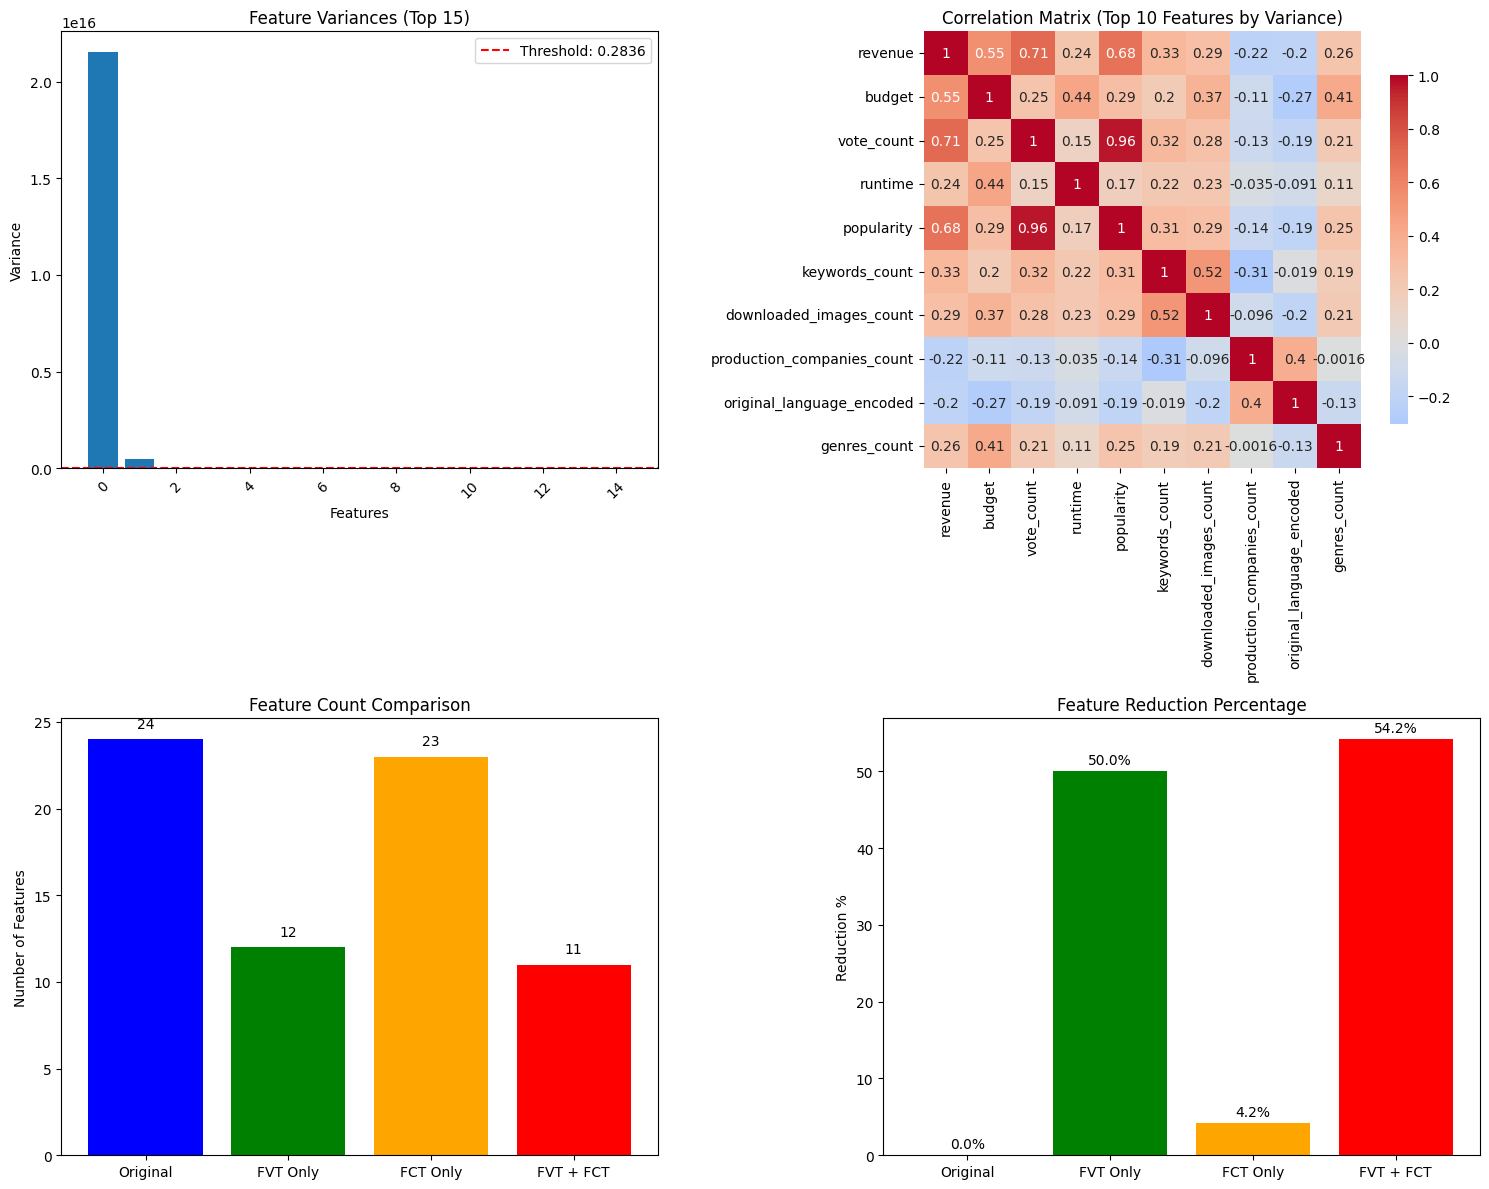


Analysis results saved to: multimodal_data\feature_analysis_results.json


In [ ]:
# Feature Variance and Correlation Analysis
print("Feature Variance and Correlation Analysis")
print("=" * 50)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

# Load movie features data
if 'all_movie_features' in locals() and all_movie_features:
    df_features = pd.DataFrame(all_movie_features)
else:
    # Try to load from file
    features_file = os.path.join(DATA_DIR, 'tmdb_movie_features.csv')
    if os.path.exists(features_file):
        df_features = pd.read_csv(features_file)
    else:
        print("ERROR: No movie features data available")
        df_features = None

if df_features is not None:
    print(f"Loaded movie features: {len(df_features)} movies, {len(df_features.columns)} features")
    
    # Define features to exclude (text features with high cardinality)
    text_features_to_exclude = [
        'overview', 'tagline', 'title', 'original_title', 
        'movielens_title', 'imdb_id', 'movielens_imdb_id',
        'image_paths', 'release_date', 'status'
    ]
    
    # Select numerical and categorical features for analysis
    numerical_features = [
        'runtime', 'vote_average', 'vote_count', 'popularity', 
        'budget', 'revenue', 'downloaded_images_count'
    ]
    
    categorical_features = [
        'genres', 'directors', 'cast', 'keywords', 
        'original_language', 'production_countries', 'production_companies'
    ]
    
    # Prepare dataset for analysis
    analysis_df = df_features.copy()
    
    # Handle missing values in numerical features
    for col in numerical_features:
        if col in analysis_df.columns:
            analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce').fillna(0)
    
    # Process categorical features - encode to numerical
    categorical_encoded = {}
    for col in categorical_features:
        if col in analysis_df.columns:
            # Handle missing values
            analysis_df[col] = analysis_df[col].fillna('')
            
            # For multi-value features (separated by |), count occurrences
            if col in ['genres', 'directors', 'cast', 'keywords', 'production_countries', 'production_companies']:
                # Count number of items (split by |)
                analysis_df[f'{col}_count'] = analysis_df[col].apply(
                    lambda x: len([item.strip() for item in str(x).split('|') if item.strip()]) if x else 0
                )
                categorical_encoded[f'{col}_count'] = f'{col}_count'
                
                # For genres, create binary features for top genres
                if col == 'genres':
                    all_genres = []
                    for genres_str in analysis_df[col]:
                        if genres_str:
                            all_genres.extend([g.strip() for g in str(genres_str).split('|')])
                    
                    # Get top 10 most common genres
                    from collections import Counter
                    top_genres = [genre for genre, count in Counter(all_genres).most_common(10)]
                    
                    for genre in top_genres:
                        col_name = f'genre_{genre.lower().replace(" ", "_").replace("-", "_")}'
                        analysis_df[col_name] = analysis_df[col].apply(
                            lambda x: 1 if genre in str(x) else 0
                        )
                        categorical_encoded[col_name] = col_name
            else:
                # Simple label encoding for single-value categorical features
                le = LabelEncoder()
                analysis_df[f'{col}_encoded'] = le.fit_transform(analysis_df[col].astype(str))
                categorical_encoded[f'{col}_encoded'] = f'{col}_encoded'
    
    # Create final feature matrix for analysis
    features_for_analysis = numerical_features + list(categorical_encoded.keys())
    features_for_analysis = [f for f in features_for_analysis if f in analysis_df.columns]
    
    print(f"\nFeatures selected for analysis: {len(features_for_analysis)}")
    print("Numerical features:", numerical_features)
    print("Encoded categorical features:", list(categorical_encoded.keys()))
    
    # Create analysis matrix
    X = analysis_df[features_for_analysis].copy()
    
    # Remove any remaining non-numerical columns
    X = X.select_dtypes(include=[np.number])
    
    print(f"\nFinal analysis matrix shape: {X.shape}")
    
    # === Feature Variance Threshold (FVT) Analysis ===
    print("\n" + "="*60)
    print("FEATURE VARIANCE THRESHOLD (FVT) ANALYSIS")
    print("="*60)
    
    # Calculate variance for each feature
    feature_variances = X.var().sort_values(ascending=False)
    
    print("\nFeature variances (top 15):")
    for i, (feature, variance) in enumerate(feature_variances.head(15).items()):
        print(f"{i+1:2d}. {feature:25s}: {variance:12.4f}")
    
    # Set variance threshold (e.g., median variance)
    variance_threshold = feature_variances.median()
    print(f"\nVariance threshold (median): {variance_threshold:.4f}")
    
    # Apply FVT
    selector_fvt = VarianceThreshold(threshold=variance_threshold)
    X_fvt = selector_fvt.fit_transform(X)
    selected_features_fvt = X.columns[selector_fvt.get_support()].tolist()
    removed_features_fvt = X.columns[~selector_fvt.get_support()].tolist()
    
    print(f"\nFVT Results:")
    print(f"Original features: {X.shape[1]}")
    print(f"Features retained: {len(selected_features_fvt)}")
    print(f"Features supposed to be remove: {len(removed_features_fvt)}")
    print(f"Reduction ratio: {len(removed_features_fvt)/X.shape[1]*100:.1f}%")
    
    if removed_features_fvt:
        print(f"\nTo be remove features (low variance): {removed_features_fvt}")
    
    # === Feature Correlation Threshold (FCT) Analysis ===
    print("\n" + "="*60)
    print("FEATURE CORRELATION THRESHOLD (FCT) ANALYSIS")
    print("="*60)
    
    # Calculate correlation matrix
    correlation_matrix = X.corr().abs()
    
    # Set correlation threshold
    correlation_threshold = 0.8
    print(f"Correlation threshold: {correlation_threshold}")
    
    # Find highly correlated pairs
    high_corr_pairs = []
    upper_triangle = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] > correlation_threshold:
                high_corr_pairs.append({
                    'feature1': correlation_matrix.columns[i],
                    'feature2': correlation_matrix.columns[j],
                    'correlation': correlation_matrix.iloc[i, j]
                })
    
    print(f"\nHighly correlated feature pairs (> {correlation_threshold}):")
    if high_corr_pairs:
        for i, pair in enumerate(high_corr_pairs, 1):
            print(f"{i:2d}. {pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")
    else:
        print("No highly correlated feature pairs found.")
    
    # Remove highly correlated features (keep first in each pair)
    features_to_remove_fct = set()
    for pair in high_corr_pairs:
        # Remove the second feature in each highly correlated pair
        features_to_remove_fct.add(pair['feature2'])
    
    selected_features_fct = [f for f in X.columns if f not in features_to_remove_fct]
    X_fct = X[selected_features_fct]
    
    print(f"\nFCT Results:")
    print(f"Original features: {X.shape[1]}")
    print(f"Features retained: {len(selected_features_fct)}")
    print(f"Features removed: {len(features_to_remove_fct)}")
    print(f"Reduction ratio: {len(features_to_remove_fct)/X.shape[1]*100:.1f}%")
    
    if features_to_remove_fct:
        print(f"\nRemoved features (high correlation): {list(features_to_remove_fct)}")
    
    # === Combined FVT + FCT Analysis ===
    print("\n" + "="*60)
    print("COMBINED FVT + FCT ANALYSIS")
    print("="*60)
    
    # Apply both methods sequentially
    # First apply FVT, then FCT on the remaining features
    X_fvt_df = pd.DataFrame(X_fvt, columns=selected_features_fvt)
    
    # Apply FCT on FVT-filtered features
    correlation_matrix_fvt = X_fvt_df.corr().abs()
    
    high_corr_pairs_fvt = []
    for i in range(len(correlation_matrix_fvt.columns)):
        for j in range(i+1, len(correlation_matrix_fvt.columns)):
            if correlation_matrix_fvt.iloc[i, j] > correlation_threshold:
                high_corr_pairs_fvt.append({
                    'feature1': correlation_matrix_fvt.columns[i],
                    'feature2': correlation_matrix_fvt.columns[j],
                    'correlation': correlation_matrix_fvt.iloc[i, j]
                })
    
    features_to_remove_combined = set()
    for pair in high_corr_pairs_fvt:
        features_to_remove_combined.add(pair['feature2'])
    
    final_features = [f for f in selected_features_fvt if f not in features_to_remove_combined]
    
    print(f"Combined FVT + FCT Results:")
    print(f"Original features: {X.shape[1]}")
    print(f"After FVT: {len(selected_features_fvt)}")
    print(f"Final features (FVT + FCT): {len(final_features)}")
    print(f"Total reduction ratio: {(X.shape[1] - len(final_features))/X.shape[1]*100:.1f}%")
    
    print(f"\nFinal selected features: {final_features}")
    
    # === Visualization ===
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Feature variances
    top_variances = feature_variances.head(15)
    axes[0, 0].bar(range(len(top_variances)), top_variances.values)
    axes[0, 0].axhline(y=variance_threshold, color='r', linestyle='--', label=f'Threshold: {variance_threshold:.4f}')
    axes[0, 0].set_title('Feature Variances (Top 15)')
    axes[0, 0].set_xlabel('Features')
    axes[0, 0].set_ylabel('Variance')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].legend()
    
    # 2. Correlation heatmap (top correlated features)
    top_features = feature_variances.head(10).index
    corr_subset = X[top_features].corr()
    sns.heatmap(corr_subset, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[0, 1], cbar_kws={'shrink': 0.8})
    axes[0, 1].set_title('Correlation Matrix (Top 10 Features by Variance)')
    
    # 3. Feature reduction comparison
    methods = ['Original', 'FVT Only', 'FCT Only', 'FVT + FCT']
    feature_counts = [X.shape[1], len(selected_features_fvt), len(selected_features_fct), len(final_features)]
    axes[1, 0].bar(methods, feature_counts, color=['blue', 'green', 'orange', 'red'])
    axes[1, 0].set_title('Feature Count Comparison')
    axes[1, 0].set_ylabel('Number of Features')
    for i, v in enumerate(feature_counts):
        axes[1, 0].text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    # 4. Reduction percentage
    reduction_percentages = [0, 
                           (X.shape[1] - len(selected_features_fvt))/X.shape[1]*100,
                           (X.shape[1] - len(selected_features_fct))/X.shape[1]*100,
                           (X.shape[1] - len(final_features))/X.shape[1]*100]
    axes[1, 1].bar(methods, reduction_percentages, color=['blue', 'green', 'orange', 'red'])
    axes[1, 1].set_title('Feature Reduction Percentage')
    axes[1, 1].set_ylabel('Reduction %')
    for i, v in enumerate(reduction_percentages):
        axes[1, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_summary = {
        'original_features': X.shape[1],
        'fvt_features': len(selected_features_fvt),
        'fct_features': len(selected_features_fct),
        'combined_features': len(final_features),
        'variance_threshold': variance_threshold,
        'correlation_threshold': correlation_threshold,
        'final_selected_features': final_features,
        'removed_by_fvt': removed_features_fvt,
        'removed_by_fct': list(features_to_remove_fct),
        'high_correlation_pairs': high_corr_pairs
    }
    
    # Save to file
    import json
    results_file = os.path.join(DATA_DIR, 'feature_analysis_results.json')
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(results_summary, f, ensure_ascii=False, indent=2)
    
    print(f"\nAnalysis results saved to: {results_file}")
    
else:
    print("No movie features data available for analysis.")

In [ ]:
# Image similarity calculation and selection - select 5 most diverse from 10
import re
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import hashlib

# Deep learning imports (optional - install if using deep learning methods)
try:
    import torch
    import torchvision.transforms as transforms
    import torchvision.models as models
    from transformers import CLIPProcessor, CLIPModel
    DEEP_LEARNING_AVAILABLE = True
except ImportError:
    DEEP_LEARNING_AVAILABLE = False
    print("Deep learning libraries not available. Install torch, torchvision, and transformers for CNN and CLIP methods.")

print("Image Similarity Calculation and Selection")
print("=" * 50)

# SIMILARITY CALCULATION METHOD SELECTION
SIMILARITY_METHOD = "histogram"  # Options: "histogram", "ssim", "perceptual_hash", "combined", "cnn_features", "clip_features"

def sanitize_filename(filename):
    """Remove or replace invalid characters for Windows file/folder names"""
    # Replace invalid characters with underscore
    invalid_chars = r'[<>:"/\\|?*]'
    sanitized = re.sub(invalid_chars, '_', filename)
    
    # Remove any trailing dots or spaces (also invalid in Windows)
    sanitized = sanitized.rstrip('. ')
    
    # Ensure the name isn't empty after sanitization
    if not sanitized.strip():
        sanitized = "unnamed"
    
    return sanitized

def calculate_histogram_similarity(img1_path, img2_path):
    """Calculate similarity between two images using HSV histogram comparison"""
    try:
        # Read images
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        
        if img1 is None or img2 is None:
            return 0.0
        
        # Convert to HSV color space
        hsv1 = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
        hsv2 = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
        
        # Calculate histograms
        hist1 = cv2.calcHist([hsv1], [0, 1, 2], None, [50, 60, 60], [0, 180, 0, 256, 0, 256])
        hist2 = cv2.calcHist([hsv2], [0, 1, 2], None, [50, 60, 60], [0, 180, 0, 256, 0, 256])
        
        # Calculate correlation
        correlation = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
        return max(0.0, correlation)  # Ensure non-negative
    
    except Exception as e:
        print(f"       Histogram similarity calculation failed: {str(e)}")
        return 0.0

def calculate_ssim_similarity(img1_path, img2_path):
    """Calculate similarity between two images using Structural Similarity Index (SSIM)"""
    try:
        # Read images
        img1 = cv2.imread(img1_path)
        img2 = cv2.imread(img2_path)
        
        if img1 is None or img2 is None:
            return 0.0
        
        # Convert to grayscale
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        
        # Resize to same dimensions for comparison
        height = min(gray1.shape[0], gray2.shape[0])
        width = min(gray1.shape[1], gray2.shape[1])
        
        gray1_resized = cv2.resize(gray1, (width, height))
        gray2_resized = cv2.resize(gray2, (width, height))
        
        # Calculate SSIM
        similarity_score = ssim(gray1_resized, gray2_resized)
        return max(0.0, similarity_score)  # Ensure non-negative
    
    except Exception as e:
        print(f"       SSIM similarity calculation failed: {str(e)}")
        return 0.0

def calculate_perceptual_hash_similarity(img1_path, img2_path):
    """Calculate similarity between two images using perceptual hashing"""
    try:
        def perceptual_hash(image_path, hash_size=8):
            """Calculate perceptual hash of an image"""
            # Open and convert to grayscale
            img = Image.open(image_path).convert('L')
            
            # Resize to hash_size x hash_size
            img = img.resize((hash_size, hash_size), Image.Resampling.LANCZOS)
            
            # Convert to numpy array
            pixels = np.array(img)
            
            # Calculate average pixel value
            avg = pixels.mean()
            
            # Create binary hash
            binary_hash = pixels > avg
            
            return binary_hash.flatten()
        
        # Calculate hashes
        hash1 = perceptual_hash(img1_path)
        hash2 = perceptual_hash(img2_path)
        
        # Calculate Hamming distance (number of different bits)
        hamming_distance = np.sum(hash1 != hash2)
        
        # Convert to similarity (0 = identical, 1 = completely different)
        max_distance = len(hash1)
        similarity = 1.0 - (hamming_distance / max_distance)
        
        return max(0.0, similarity)
    
    except Exception as e:
        print(f"       Perceptual hash similarity calculation failed: {str(e)}")
        return 0.0

def calculate_combined_similarity(img1_path, img2_path):
    """Calculate similarity using a combination of multiple methods"""
    try:
        # Weight for each method
        weights = {
            'histogram': 0.4,
            'ssim': 0.4,
            'perceptual': 0.2
        }
        
        # Calculate individual similarities
        hist_sim = calculate_histogram_similarity(img1_path, img2_path)
        ssim_sim = calculate_ssim_similarity(img1_path, img2_path)
        hash_sim = calculate_perceptual_hash_similarity(img1_path, img2_path)
        
        # Weighted combination
        combined_sim = (weights['histogram'] * hist_sim + 
                       weights['ssim'] * ssim_sim + 
                       weights['perceptual'] * hash_sim)
        
        return max(0.0, combined_sim)
    
    except Exception as e:
        print(f"       Combined similarity calculation failed: {str(e)}")
        return 0.0

# Global variables for CNN model (to avoid reloading)
_cnn_model = None
_cnn_transform = None

def calculate_cnn_features_similarity(img1_path, img2_path):
    """Calculate similarity using pre-trained CNN features (ResNet-50)"""
    if not DEEP_LEARNING_AVAILABLE:
        print("       CNN features method requires torch and torchvision")
        return 0.0
    
    global _cnn_model, _cnn_transform
    
    try:
        # Load model and transform once
        if _cnn_model is None:
            print("       Loading ResNet-50 model (first time only)...")
            _cnn_model = models.resnet50(pretrained=True)
            _cnn_model.eval()
            # Remove the final classification layer to get features
            _cnn_model = torch.nn.Sequential(*list(_cnn_model.children())[:-1])
            
            _cnn_transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                   std=[0.229, 0.224, 0.225]),
            ])
        
        def extract_cnn_features(image_path):
            """Extract CNN features from an image"""
            image = Image.open(image_path).convert('RGB')
            image_tensor = _cnn_transform(image).unsqueeze(0)
            
            with torch.no_grad():
                features = _cnn_model(image_tensor)
                features = features.squeeze().numpy()
            
            return features
        
        # Extract features
        features1 = extract_cnn_features(img1_path)
        features2 = extract_cnn_features(img2_path)
        
        # Calculate cosine similarity
        dot_product = np.dot(features1, features2)
        norm1 = np.linalg.norm(features1)
        norm2 = np.linalg.norm(features2)
        
        if norm1 == 0 or norm2 == 0:
            return 0.0
        
        cosine_sim = dot_product / (norm1 * norm2)
        # Convert from [-1, 1] to [0, 1]
        similarity = (cosine_sim + 1) / 2
        
        return max(0.0, min(1.0, similarity))
    
    except Exception as e:
        print(f"       CNN features similarity calculation failed: {str(e)}")
        return 0.0

# Global variables for CLIP model
_clip_model = None
_clip_processor = None

def calculate_clip_features_similarity(img1_path, img2_path):
    """Calculate similarity using CLIP model features"""
    if not DEEP_LEARNING_AVAILABLE:
        print("       CLIP features method requires transformers library")
        return 0.0
    
    global _clip_model, _clip_processor
    
    try:
        # Load CLIP model and processor once
        if _clip_model is None:
            print("       Loading CLIP model (first time only)...")
            _clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
            _clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        
        def extract_clip_features(image_path):
            """Extract CLIP features from an image"""
            image = Image.open(image_path).convert('RGB')
            inputs = _clip_processor(images=image, return_tensors="pt")
            
            with torch.no_grad():
                image_features = _clip_model.get_image_features(**inputs)
                # Normalize features
                image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
            
            return image_features.squeeze().numpy()
        
        # Extract features
        features1 = extract_clip_features(img1_path)
        features2 = extract_clip_features(img2_path)
        
        # Calculate cosine similarity
        cosine_sim = np.dot(features1, features2)
        # CLIP features are already normalized, so dot product gives cosine similarity
        # Convert from [-1, 1] to [0, 1]
        similarity = (cosine_sim + 1) / 2
        
        return max(0.0, min(1.0, similarity))
    
    except Exception as e:
        print(f"       CLIP features similarity calculation failed: {str(e)}")
        return 0.0

def calculate_image_similarity(img1_path, img2_path, method=SIMILARITY_METHOD):
    """Calculate similarity between two images using specified method"""
    method_functions = {
        'histogram': calculate_histogram_similarity,
        'ssim': calculate_ssim_similarity,
        'perceptual_hash': calculate_perceptual_hash_similarity,
        'combined': calculate_combined_similarity,
        'cnn_features': calculate_cnn_features_similarity,
        'clip_features': calculate_clip_features_similarity
    }
    
    if method not in method_functions:
        print(f"   WARNING: Unknown similarity method '{method}', using 'histogram'")
        method = 'histogram'
    
    # Check if deep learning methods are available
    if method in ['cnn_features', 'clip_features'] and not DEEP_LEARNING_AVAILABLE:
        print(f"   WARNING: Deep learning method '{method}' not available, using 'histogram'")
        method = 'histogram'
    
    return method_functions[method](img1_path, img2_path)

def select_diverse_images(image_paths, target_count=5, similarity_method=SIMILARITY_METHOD):
    """Select the most diverse target_count images from the image list"""
    if len(image_paths) <= target_count:
        return image_paths
    
    print(f"       Using similarity method: {similarity_method}")
    
    # Calculate similarity matrix for all image pairs
    n = len(image_paths)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            sim = calculate_image_similarity(image_paths[i], image_paths[j], similarity_method)
            similarity_matrix[i][j] = sim
            similarity_matrix[j][i] = sim
    
    # Greedy algorithm to select most dissimilar images
    selected_indices = [0]  # Start with first image
    
    for _ in range(target_count - 1):
        max_min_sim = -1
        best_candidate = -1
        
        for candidate in range(n):
            if candidate in selected_indices:
                continue
            
            # Calculate minimum similarity with already selected images
            min_sim = min(similarity_matrix[candidate][selected] for selected in selected_indices)
            
            if min_sim > max_min_sim:
                max_min_sim = min_sim
                best_candidate = candidate
        
        if best_candidate != -1:
            selected_indices.append(best_candidate)
    
    return [image_paths[i] for i in selected_indices]

# Print current configuration
print(f"Current similarity calculation method: {SIMILARITY_METHOD}")
print("Available methods:")
print("Traditional Computer Vision Methods:")
print("  - 'histogram': HSV color histogram correlation")
print("  - 'ssim': Structural Similarity Index")
print("  - 'perceptual_hash': Perceptual hashing based on image structure")
print("  - 'combined': Weighted combination of traditional methods")

if DEEP_LEARNING_AVAILABLE:
    print("Deep Learning Methods:")
    print("  - 'cnn_features': Pre-trained ResNet-50 CNN features")
    print("  - 'clip_features': CLIP multimodal model features")
else:
    print("Deep Learning Methods (Not Available - install requirements):")
    print("  - 'cnn_features': Pre-trained ResNet-50 CNN features [REQUIRES: torch, torchvision]")
    print("  - 'clip_features': CLIP multimodal model features [REQUIRES: transformers]")

print()
print("Method Characteristics:")
print("  Traditional methods: Fast, lightweight, good for basic similarity")
print("  CNN features: Captures high-level visual features, better semantic understanding")
print("  CLIP features: Best semantic similarity, trained on image-text pairs")
print()

# Filter images for each movie
if 'all_movie_features' in locals() and all_movie_features:
    print(f"Starting image selection for {len(all_movie_features)} movies")
    
    selected_image_stats = []
    total_selected = 0
    
    for movie_features in tqdm(all_movie_features, desc="Selecting images"):
        movie_id = movie_features['movielens_id']
        title = movie_features['movielens_title']
        
        # Get image paths
        image_paths = movie_features.get('image_paths', [])
        
        if not image_paths:
            print(f"   WARNING: {movie_id}. {title}: No images found")
            continue
        
        # Verify image files exist
        valid_paths = [path for path in image_paths if os.path.exists(path)]
        
        if len(valid_paths) == 0:
            print(f"   ERROR: {movie_id}. {title}: Image files do not exist")
            continue
        
        # Select most diverse images
        selected_paths = select_diverse_images(valid_paths, SELECTED_IMAGES, SIMILARITY_METHOD)
        
        # Create selected image directory and copy images
        # FIXED: Sanitize the title to remove invalid characters
        sanitized_title = sanitize_filename(title[:50])
        selected_folder = os.path.join(SELECTED_IMAGE_DIR, f"{movie_id:04d}_{sanitized_title}")
        
        try:
            os.makedirs(selected_folder, exist_ok=True)
        except Exception as e:
            print(f"   ERROR: Failed to create directory for {movie_id}. {title}: {str(e)}")
            # Fallback: use only movie ID as folder name
            selected_folder = os.path.join(SELECTED_IMAGE_DIR, f"{movie_id:04d}")
            os.makedirs(selected_folder, exist_ok=True)
        
        copied_paths = []
        for i, src_path in enumerate(selected_paths):
            filename = f"selected_{i+1}.jpg"
            dst_path = os.path.join(selected_folder, filename)
            
            try:
                # Copy image
                img = Image.open(src_path)
                img.save(dst_path, "JPEG", quality=90)
                copied_paths.append(dst_path)
            except Exception as e:
                print(f"     ERROR: Failed to copy image: {str(e)}")
        
        # Update feature data
        movie_features['selected_image_paths'] = copied_paths
        movie_features['selected_images_count'] = len(copied_paths)
        movie_features['similarity_method_used'] = SIMILARITY_METHOD
        
        selected_image_stats.append({
            'movie_id': movie_id,
            'title': title,
            'original_count': len(valid_paths),
            'selected_count': len(copied_paths)
        })
        
        total_selected += len(copied_paths)
        
        print(f"   SUCCESS: {movie_id}. {title}: {len(valid_paths)} -> {len(copied_paths)} images")
    
    # Save updated feature data
    updated_features_file = os.path.join(DATA_DIR, 'movie_features_with_selected_images.json')
    with open(updated_features_file, 'w', encoding='utf-8') as f:
        json.dump(all_movie_features, f, ensure_ascii=False, indent=2)
    
    print(f"\nImage selection statistics:")
    print(f"   Similarity method used: {SIMILARITY_METHOD}")
    print(f"   Movies processed: {len(selected_image_stats)}")
    print(f"   Total selected images: {total_selected}")
    print(f"   Average per movie: {total_selected/len(selected_image_stats):.1f} images")
    print(f"   Updated data saved: {updated_features_file}")
    
    # Display selection details
    stats_df = pd.DataFrame(selected_image_stats)
    print(f"\nSelection details:")
    print(f"   Original images total: {stats_df['original_count'].sum()}")
    print(f"   Selected images total: {stats_df['selected_count'].sum()}")
    print(f"   Selection rate: {stats_df['selected_count'].sum()/stats_df['original_count'].sum()*100:.1f}%")
    
else:
    print("ERROR: No movie feature data available for image selection")

# Example of how to change similarity method:
print("\n" + "="*50)
print("To change similarity calculation method, modify the SIMILARITY_METHOD variable:")
print("# Traditional methods:")
print("SIMILARITY_METHOD = 'histogram'       # Color-based similarity (fastest)")
print("SIMILARITY_METHOD = 'ssim'            # Structural similarity") 
print("SIMILARITY_METHOD = 'perceptual_hash' # Content-based similarity")
print("SIMILARITY_METHOD = 'combined'        # Combination of traditional methods")
print()
print("# Deep learning methods (require additional libraries):")
print("SIMILARITY_METHOD = 'cnn_features'    # CNN features (good semantic understanding)")
print("SIMILARITY_METHOD = 'clip_features'   # CLIP features (best semantic similarity)")
print()
print("Installation requirements for deep learning methods:")
print("pip install torch torchvision        # For CNN features")
print("pip install transformers torch       # For CLIP features")

Image Similarity Calculation and Selection
Current similarity calculation method: clip_features
Available methods:
Traditional Computer Vision Methods:
  - 'histogram': HSV color histogram correlation
  - 'ssim': Structural Similarity Index
  - 'perceptual_hash': Perceptual hashing based on image structure
  - 'combined': Weighted combination of traditional methods
Deep Learning Methods:
  - 'cnn_features': Pre-trained ResNet-50 CNN features
  - 'clip_features': CLIP multimodal model features

Method Characteristics:
  Traditional methods: Fast, lightweight, good for basic similarity
  CNN features: Captures high-level visual features, better semantic understanding
  CLIP features: Best semantic similarity, trained on image-text pairs

Starting image selection for 52 movies


Selecting images:   0%|          | 0/52 [00:00<?, ?it/s]

       Using similarity method: clip_features
       Loading CLIP model (first time only)...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Selecting images:   2%|▏         | 1/52 [00:04<03:26,  4.05s/it]

   SUCCESS: 1. Toy Story: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:   4%|▍         | 2/52 [00:07<02:54,  3.49s/it]

   SUCCESS: 2. GoldenEye: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:   6%|▌         | 3/52 [00:10<02:42,  3.32s/it]

   SUCCESS: 3. Four Rooms: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:   8%|▊         | 4/52 [00:13<02:35,  3.24s/it]

   SUCCESS: 4. Get Shorty: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  10%|▉         | 5/52 [00:16<02:29,  3.19s/it]

   SUCCESS: 5. Copycat: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  12%|█▏        | 6/52 [00:17<02:00,  2.61s/it]

   SUCCESS: 6. Shanghai Triad (Yao a yao yao dao waipo qiao): 7 -> 5 images
       Using similarity method: clip_features


Selecting images:  13%|█▎        | 7/52 [00:21<02:04,  2.77s/it]

   SUCCESS: 7. Twelve Monkeys: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  15%|█▌        | 8/52 [00:24<02:16,  3.09s/it]

   SUCCESS: 8. Babe: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  17%|█▋        | 9/52 [00:28<02:23,  3.34s/it]

   SUCCESS: 9. Dead Man Walking: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  19%|█▉        | 10/52 [00:30<02:00,  2.86s/it]

   SUCCESS: 10. Richard III: 7 -> 5 images
       Using similarity method: clip_features


Selecting images:  21%|██        | 11/52 [00:34<02:09,  3.16s/it]

   SUCCESS: 11. Seven (Se7en): 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  23%|██▎       | 12/52 [00:38<02:15,  3.38s/it]

   SUCCESS: 12. Usual Suspects, The: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  25%|██▌       | 13/52 [00:42<02:18,  3.56s/it]

   SUCCESS: 13. Mighty Aphrodite: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  27%|██▋       | 14/52 [00:46<02:20,  3.69s/it]

   SUCCESS: 14. Postino, Il: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  29%|██▉       | 15/52 [00:50<02:18,  3.74s/it]

   SUCCESS: 15. Mr. Holland's Opus: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  31%|███       | 16/52 [00:53<02:15,  3.76s/it]

   SUCCESS: 16. French Twist (Gazon maudit): 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  33%|███▎      | 17/52 [00:57<02:11,  3.77s/it]

   SUCCESS: 17. From Dusk Till Dawn: 10 -> 5 images
   SUCCESS: 18. White Balloon, The: 4 -> 4 images
       Using similarity method: clip_features


Selecting images:  37%|███▋      | 19/52 [00:59<01:20,  2.43s/it]

   SUCCESS: 19. Antonia's Line: 7 -> 5 images
       Using similarity method: clip_features


Selecting images:  38%|███▊      | 20/52 [01:01<01:16,  2.40s/it]

   SUCCESS: 20. Angels and Insects: 8 -> 5 images
       Using similarity method: clip_features


Selecting images:  40%|████      | 21/52 [01:05<01:24,  2.74s/it]

   SUCCESS: 21. Muppet Treasure Island: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  42%|████▏     | 22/52 [01:09<01:29,  2.99s/it]

   SUCCESS: 22. Braveheart: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  44%|████▍     | 23/52 [01:12<01:32,  3.18s/it]

   SUCCESS: 23. Taxi Driver: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  46%|████▌     | 24/52 [01:16<01:33,  3.33s/it]

   SUCCESS: 24. Rumble in the Bronx: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  48%|████▊     | 25/52 [01:20<01:32,  3.43s/it]

   SUCCESS: 25. Birdcage, The: 10 -> 5 images
   SUCCESS: 26. Brothers McMullen, The: 4 -> 4 images
       Using similarity method: clip_features


Selecting images:  52%|█████▏    | 27/52 [01:23<01:07,  2.72s/it]

   SUCCESS: 27. Bad Boys: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  54%|█████▍    | 28/52 [01:27<01:11,  2.96s/it]

   SUCCESS: 28. Apollo 13: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  56%|█████▌    | 29/52 [01:31<01:12,  3.15s/it]

   SUCCESS: 29. Batman Forever: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  58%|█████▊    | 30/52 [01:34<01:12,  3.29s/it]

   SUCCESS: 30. Belle de jour: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  60%|█████▉    | 31/52 [01:38<01:11,  3.40s/it]

   SUCCESS: 31. Crimson Tide: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  62%|██████▏   | 32/52 [01:42<01:09,  3.49s/it]

   SUCCESS: 32. Crumb: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  63%|██████▎   | 33/52 [01:46<01:07,  3.54s/it]

   SUCCESS: 33. Desperado: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  65%|██████▌   | 34/52 [01:49<01:04,  3.58s/it]

   SUCCESS: 34. Doom Generation, The: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  67%|██████▋   | 35/52 [01:53<01:01,  3.61s/it]

   SUCCESS: 35. Free Willy 2: The Adventure Home: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  69%|██████▉   | 36/52 [01:56<00:54,  3.43s/it]

   SUCCESS: 36. Mad Love: 9 -> 5 images
       Using similarity method: clip_features


Selecting images:  71%|███████   | 37/52 [01:57<00:41,  2.78s/it]

   SUCCESS: 37. Nadja: 6 -> 5 images
       Using similarity method: clip_features


Selecting images:  73%|███████▎  | 38/52 [02:01<00:42,  3.05s/it]

   SUCCESS: 38. Net, The: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  75%|███████▌  | 39/52 [02:04<00:42,  3.25s/it]

   SUCCESS: 39. Strange Days: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  77%|███████▋  | 40/52 [02:08<00:40,  3.39s/it]

   SUCCESS: 40. To Wong Foo, Thanks for Everything! Julie Newmar: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  79%|███████▉  | 41/52 [02:11<00:35,  3.26s/it]

   SUCCESS: 41. Billy Madison: 9 -> 5 images
       Using similarity method: clip_features


Selecting images:  81%|████████  | 42/52 [02:15<00:34,  3.40s/it]

   SUCCESS: 42. Clerks: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  83%|████████▎ | 43/52 [02:19<00:31,  3.49s/it]

   SUCCESS: 43. Disclosure: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  85%|████████▍ | 44/52 [02:22<00:28,  3.56s/it]

   SUCCESS: 44. Dolores Claiborne: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  87%|████████▋ | 45/52 [02:26<00:25,  3.64s/it]

   SUCCESS: 45. Eat Drink Man Woman: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  88%|████████▊ | 46/52 [02:31<00:23,  3.95s/it]

   SUCCESS: 46. Exotica: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  90%|█████████ | 47/52 [02:36<00:21,  4.31s/it]

   SUCCESS: 47. Ed Wood: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  92%|█████████▏| 48/52 [02:39<00:16,  4.02s/it]

   SUCCESS: 48. Hoop Dreams: 8 -> 5 images
       Using similarity method: clip_features


Selecting images:  94%|█████████▍| 49/52 [02:43<00:12,  4.06s/it]

   SUCCESS: 49. I.Q.: 9 -> 5 images
       Using similarity method: clip_features


Selecting images:  96%|█████████▌| 50/52 [02:49<00:08,  4.37s/it]

   SUCCESS: 50. Star Wars: 10 -> 5 images
       Using similarity method: clip_features


Selecting images:  98%|█████████▊| 51/52 [02:54<00:04,  4.60s/it]

   SUCCESS: 51. Legends of the Fall: 10 -> 5 images
       Using similarity method: clip_features


Selecting images: 100%|██████████| 52/52 [02:55<00:00,  3.38s/it]

   SUCCESS: 52. Madness of King George, The: 6 -> 5 images

Image selection statistics:
   Similarity method used: clip_features
   Movies processed: 52
   Total selected images: 258
   Average per movie: 5.0 images
   Updated data saved: multimodal_data\movie_features_with_selected_images.json

Selection details:
   Original images total: 484
   Selected images total: 258
   Selection rate: 53.3%

To change similarity calculation method, modify the SIMILARITY_METHOD variable:
# Traditional methods:
SIMILARITY_METHOD = 'histogram'       # Color-based similarity (fastest)
SIMILARITY_METHOD = 'ssim'            # Structural similarity
SIMILARITY_METHOD = 'perceptual_hash' # Content-based similarity
SIMILARITY_METHOD = 'combined'        # Combination of traditional methods

# Deep learning methods (require additional libraries):
SIMILARITY_METHOD = 'cnn_features'    # CNN features (good semantic understanding)
SIMILARITY_METHOD = 'clip_features'   # CLIP features (best semantic similarity)

In [22]:
# Optional: Compare different similarity calculation methods
# Set this to True to run the comparison
RUN_COMPARISON = True # Change to True to enable comparison

if RUN_COMPARISON:
    import time
    import pandas as pd
    import random
    from statistics import mean, stdev
    
    print("="*70)
    print("SIMILARITY METHODS COMPARISON")
    print("="*70)
    
    # Check if required functions are available
    required_functions = ['calculate_image_similarity']
    missing_functions = []
    
    for func_name in required_functions:
        if func_name not in globals():
            missing_functions.append(func_name)
    
    if missing_functions:
        print(f"ERROR: Required functions not found: {missing_functions}")
        print("Please run the main image selection cell first to define all required functions")
        print("Set RUN_COMPARISON = False to disable this check")
    else:
        print("✓ All required functions are available")
    
    # Sample selection for comparison
    COMPARISON_SAMPLE_SIZE = 10  # Number of images to use for comparison
    MAX_MOVIES_TO_TEST = 5       # Number of movies to test (to limit computation time)
    
    print(f"📋 Comparison Configuration:")
    print(f"   Sample Size: {COMPARISON_SAMPLE_SIZE} images")
    print(f"   Max Movies: {MAX_MOVIES_TO_TEST}")
    print(f"   Total Comparisons per Method: {COMPARISON_SAMPLE_SIZE * (COMPARISON_SAMPLE_SIZE - 1) // 2}")
    print(f"   Estimated Time per Method:")
    print(f"     - Traditional methods: 10-60 seconds")
    print(f"     - Deep learning methods: 2-10 minutes")
    print()
    
    def collect_sample_images():
        """Collect sample images from processed movies for comparison"""
        sample_images = []
        
        # Check if movie feature data is available
        try:
            # Try to access the global variable
            movie_data = globals().get('all_movie_features', None)
            if movie_data is None:
                print("ERROR: all_movie_features variable not found in global scope")
                print("Please run the main image selection cell first to load movie data")
                return None
            
            if not movie_data:
                print("ERROR: all_movie_features is empty")
                return None
                
        except Exception as e:
            print(f"ERROR: Cannot access movie feature data: {str(e)}")
            return None
        
        # Collect images from multiple movies
        movies_with_images = [movie for movie in movie_data 
                            if movie.get('image_paths') and len(movie.get('image_paths', [])) >= 3]
        
        if len(movies_with_images) == 0:
            print("ERROR: No movies with sufficient images found")
            print("Make sure the main image selection process has been completed")
            return None
        
        print(f"Found {len(movies_with_images)} movies with sufficient images")
        
        # Randomly select movies for testing
        test_movies = random.sample(movies_with_images, 
                                  min(MAX_MOVIES_TO_TEST, len(movies_with_images)))
        
        for movie in test_movies:
            valid_paths = [path for path in movie.get('image_paths', []) 
                         if os.path.exists(path)]
            
            if len(valid_paths) == 0:
                print(f"Warning: No valid image paths found for movie {movie.get('movielens_title', 'Unknown')}")
                continue
            
            # Take up to COMPARISON_SAMPLE_SIZE//MAX_MOVIES_TO_TEST images per movie
            images_per_movie = max(1, COMPARISON_SAMPLE_SIZE // MAX_MOVIES_TO_TEST)
            selected = random.sample(valid_paths, 
                                   min(images_per_movie, len(valid_paths)))
            sample_images.extend(selected)
            
            print(f"Selected {len(selected)} images from movie: {movie.get('movielens_title', 'Unknown')}")
        
        # Ensure we don't exceed the sample size
        if len(sample_images) > COMPARISON_SAMPLE_SIZE:
            sample_images = random.sample(sample_images, COMPARISON_SAMPLE_SIZE)
        
        return sample_images
    
    def calculate_similarity_matrix(image_paths, method_name):
        """Calculate similarity matrix for given images using specified method"""
        n = len(image_paths)
        similarities = []
        time_records = []
        
        total_start_time = time.time()
        
        for i in range(n):
            for j in range(i + 1, n):  # Only calculate upper triangle to avoid duplicates
                comparison_start = time.time()
                sim = calculate_image_similarity(image_paths[i], image_paths[j], method_name)
                comparison_end = time.time()
                
                similarities.append(sim)
                time_records.append(comparison_end - comparison_start)
        
        total_end_time = time.time()
        total_computation_time = total_end_time - total_start_time
        
        # Calculate time statistics
        time_stats = {
            'total_time': total_computation_time,
            'avg_time_per_comparison': np.mean(time_records) if time_records else 0.0,
            'min_time_per_comparison': min(time_records) if time_records else 0.0,
            'max_time_per_comparison': max(time_records) if time_records else 0.0,
            'std_time_per_comparison': np.std(time_records) if time_records else 0.0,
            'total_comparisons': len(similarities)
        }
        
        return similarities, time_stats
    
    def run_methods_comparison():
        """Run comparison of all available similarity methods"""
        
        # Collect sample images
        print("Collecting sample images for comparison...")
        sample_images = collect_sample_images()
        
        if sample_images is None:
            print("SOLUTION: Please run the main image selection cell first to generate all_movie_features")
            return None, None
        
        if len(sample_images) < 3:
            print(f"ERROR: Need at least 3 images for comparison, found {len(sample_images)}")
            print("Try increasing MAX_MOVIES_TO_TEST or check if image files exist")
            return None, None
        
        print(f"Selected {len(sample_images)} images from {MAX_MOVIES_TO_TEST} movies for comparison")
        print(f"Total similarity calculations per method: {len(sample_images) * (len(sample_images) - 1) // 2}")
        print()
        
        # Define methods to test
        methods_to_test = ['histogram', 'ssim', 'perceptual_hash', 'combined']
        
        # Add deep learning methods if available
        if DEEP_LEARNING_AVAILABLE:
            methods_to_test.extend(['cnn_features', 'clip_features'])
        
        # Store results
        results = []
        
        # Test each method
        for method in methods_to_test:
            print(f"Testing method: {method}...")
            
            try:
                similarities, time_stats = calculate_similarity_matrix(sample_images, method)
                
                if similarities:
                    avg_similarity = mean(similarities)
                    std_similarity = stdev(similarities) if len(similarities) > 1 else 0.0
                    min_similarity = min(similarities)
                    max_similarity = max(similarities)
                    
                    results.append({
                        'Method': method,
                        'Average Similarity': avg_similarity,
                        'Std Deviation': std_similarity,
                        'Min Similarity': min_similarity,
                        'Max Similarity': max_similarity,
                        'Total Time (s)': time_stats['total_time'],
                        'Avg Time per Comparison (ms)': time_stats['avg_time_per_comparison'] * 1000,
                        'Min Time per Comparison (ms)': time_stats['min_time_per_comparison'] * 1000,
                        'Max Time per Comparison (ms)': time_stats['max_time_per_comparison'] * 1000,
                        'Std Time per Comparison (ms)': time_stats['std_time_per_comparison'] * 1000,
                        'Total Comparisons': time_stats['total_comparisons'],
                        'Comparisons per Second': time_stats['total_comparisons'] / time_stats['total_time'] if time_stats['total_time'] > 0 else 0,
                        'Status': 'Success'
                    })
                    
                    print(f"  ✓ Completed - Avg: {avg_similarity:.3f}, Time: {time_stats['total_time']:.2f}s, Speed: {time_stats['total_comparisons']/time_stats['total_time']:.1f} comp/s")
                else:
                    results.append({
                        'Method': method,
                        'Average Similarity': 0.0,
                        'Std Deviation': 0.0,
                        'Min Similarity': 0.0,
                        'Max Similarity': 0.0,
                        'Total Time (s)': time_stats.get('total_time', 0.0),
                        'Avg Time per Comparison (ms)': 0.0,
                        'Min Time per Comparison (ms)': 0.0,
                        'Max Time per Comparison (ms)': 0.0,
                        'Std Time per Comparison (ms)': 0.0,
                        'Total Comparisons': 0,
                        'Comparisons per Second': 0.0,
                        'Status': 'Failed - No similarities calculated'
                    })
                    print(f"  ✗ Failed - No similarities calculated")
                    
            except Exception as e:
                results.append({
                    'Method': method,
                    'Average Similarity': 0.0,
                    'Std Deviation': 0.0,
                    'Min Similarity': 0.0,
                    'Max Similarity': 0.0,
                    'Total Time (s)': 0.0,
                    'Avg Time per Comparison (ms)': 0.0,
                    'Min Time per Comparison (ms)': 0.0,
                    'Max Time per Comparison (ms)': 0.0,
                    'Std Time per Comparison (ms)': 0.0,
                    'Total Comparisons': 0,
                    'Comparisons per Second': 0.0,
                    'Status': f'Error: {str(e)[:50]}...'
                })
                print(f"  ✗ Error: {str(e)}")
        
        return results, sample_images
    
    def display_comparison_results(results):
        """Display comparison results in a formatted table"""
        df = pd.DataFrame(results)
        
        print("\n" + "="*80)
        print("SIMILARITY METHODS COMPARISON RESULTS")
        print("="*80)
        
        # Create a more readable display
        print("\n📊 SIMILARITY STATISTICS:")
        print("-" * 80)
        similarity_cols = ['Method', 'Average Similarity', 'Std Deviation', 'Min Similarity', 'Max Similarity']
        print(df[similarity_cols].to_string(index=False, float_format='%.4f'))
        
        print("\n⏱️  DETAILED TIME PERFORMANCE:")
        print("-" * 80)
        time_cols = ['Method', 'Total Time (s)', 'Avg Time per Comparison (ms)', 
                    'Min Time per Comparison (ms)', 'Max Time per Comparison (ms)', 
                    'Comparisons per Second']
        time_df = df[time_cols].copy()
        
        # Format time columns for better readability
        time_df['Total Time (s)'] = time_df['Total Time (s)'].apply(lambda x: f"{x:.2f}")
        time_df['Avg Time per Comparison (ms)'] = time_df['Avg Time per Comparison (ms)'].apply(lambda x: f"{x:.2f}")
        time_df['Min Time per Comparison (ms)'] = time_df['Min Time per Comparison (ms)'].apply(lambda x: f"{x:.2f}")
        time_df['Max Time per Comparison (ms)'] = time_df['Max Time per Comparison (ms)'].apply(lambda x: f"{x:.2f}")
        time_df['Comparisons per Second'] = time_df['Comparisons per Second'].apply(lambda x: f"{x:.1f}")
        
        print(time_df.to_string(index=False))
        
        print("\n📈 TIME VARIABILITY:")
        print("-" * 80)
        variability_cols = ['Method', 'Std Time per Comparison (ms)', 'Total Comparisons', 'Status']
        var_df = df[variability_cols].copy()
        var_df['Std Time per Comparison (ms)'] = var_df['Std Time per Comparison (ms)'].apply(lambda x: f"{x:.2f}")
        print(var_df.to_string(index=False))
        
        print("\n🏆 METHOD RANKINGS:")
        print("-" * 80)
        
        # Rank by average similarity (diversity perspective - lower is better for diverse selection)
        successful_results = df[df['Status'] == 'Success'].copy()
        
        if len(successful_results) > 0:
            # Rank by speed (higher comparisons per second is better)
            successful_results['Speed Rank'] = successful_results['Comparisons per Second'].rank(ascending=False)
            
            # Rank by diversity (lower average similarity is better for diverse selection)
            successful_results['Diversity Rank'] = successful_results['Average Similarity'].rank()
            
            # Rank by consistency (lower time std is better)
            successful_results['Consistency Rank'] = successful_results['Std Time per Comparison (ms)'].rank()
            
            # Combined rank (lower is better)
            successful_results['Combined Rank'] = (successful_results['Speed Rank'] + 
                                                 successful_results['Diversity Rank'] + 
                                                 successful_results['Consistency Rank']) / 3
            
            ranking_cols = ['Method', 'Speed Rank', 'Diversity Rank', 'Consistency Rank', 'Combined Rank']
            ranking_df = successful_results[ranking_cols].sort_values('Combined Rank')
            print(ranking_df.to_string(index=False, float_format='%.1f'))
            
            print(f"\n🥇 BEST PERFORMERS:")
            print(f"   Overall Best: {ranking_df.iloc[0]['Method']}")
            print(f"   Fastest: {successful_results.loc[successful_results['Speed Rank'].idxmin(), 'Method']}")
            print(f"   Most Diverse Selection: {successful_results.loc[successful_results['Diversity Rank'].idxmin(), 'Method']}")
            print(f"   Most Consistent: {successful_results.loc[successful_results['Consistency Rank'].idxmin(), 'Method']}")
            
            # Time efficiency analysis
            print(f"\n⚡ TIME EFFICIENCY ANALYSIS:")
            fastest = successful_results.loc[successful_results['Comparisons per Second'].idxmax()]
            slowest = successful_results.loc[successful_results['Comparisons per Second'].idxmin()]
            speedup = fastest['Comparisons per Second'] / slowest['Comparisons per Second']
            
            print(f"   Fastest method: {fastest['Method']} ({fastest['Comparisons per Second']:.1f} comp/s)")
            print(f"   Slowest method: {slowest['Method']} ({slowest['Comparisons per Second']:.1f} comp/s)")
            print(f"   Speed difference: {speedup:.1f}x faster")
            
            # Time scaling estimates
            print(f"\n📈 TIME SCALING ESTIMATES (for 1000 comparisons):")
            for _, row in successful_results.iterrows():
                time_for_1000 = 1000 / row['Comparisons per Second']
                print(f"   {row['Method']:15}: {time_for_1000:8.1f} seconds")
        
        print("\n📝 INTERPRETATION GUIDE:")
        print("-" * 80)
        print("• Lower Average Similarity = Better for diverse image selection")
        print("• Higher Comparisons per Second = Faster processing")
        print("• Lower Time Std = More consistent performance")
        print("• Combined Rank considers speed, diversity, and consistency")
        print("• For large datasets, prioritize methods with high 'Comparisons per Second'")
        print("• For quality, consider methods with low 'Average Similarity'")
        
        return df
    
    def save_comparison_results(results, sample_images):
        """Save comparison results to file"""
        try:
            # Save detailed results
            results_df = pd.DataFrame(results)
            results_file = os.path.join(DATA_DIR, 'similarity_methods_comparison.csv')
            results_df.to_csv(results_file, index=False)
            
            # Create a summary report
            summary_file = os.path.join(DATA_DIR, 'similarity_comparison_summary.txt')
            with open(summary_file, 'w', encoding='utf-8') as f:
                f.write("SIMILARITY METHODS COMPARISON SUMMARY\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Comparison Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Sample Size: {len(sample_images)} images\n")
                f.write(f"Total Methods Tested: {len(results)}\n\n")
                
                # Write performance summary
                successful_results = [r for r in results if r['Status'] == 'Success']
                if successful_results:
                    f.write("PERFORMANCE SUMMARY:\n")
                    f.write("-" * 30 + "\n")
                    for result in successful_results:
                        f.write(f"{result['Method']:15}: {result['Comparisons per Second']:6.1f} comp/s, ")
                        f.write(f"Avg Sim: {result['Average Similarity']:.3f}\n")
                    
                    fastest = max(successful_results, key=lambda x: x['Comparisons per Second'])
                    most_diverse = min(successful_results, key=lambda x: x['Average Similarity'])
                    
                    f.write(f"\nFastest Method: {fastest['Method']}\n")
                    f.write(f"Most Diverse: {most_diverse['Method']}\n")
            
            # Save sample images list
            sample_info = {
                'sample_images': sample_images,
                'sample_size': len(sample_images),
                'comparison_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
                'methods_tested': [r['Method'] for r in results],
                'total_time_spent': sum(r.get('Total Time (s)', 0) for r in results),
                'total_comparisons': sum(r.get('Total Comparisons', 0) for r in results)
            }
            
            sample_file = os.path.join(DATA_DIR, 'similarity_comparison_sample_info.json')
            with open(sample_file, 'w') as f:
                json.dump(sample_info, f, indent=2)
            
            print(f"\n💾 Results saved to:")
            print(f"   - Detailed data: {results_file}")
            print(f"   - Summary report: {summary_file}")
            print(f"   - Sample info: {sample_file}")
            
        except Exception as e:
            print(f"Error saving results: {str(e)}")
    
    # Run the comparison only if all required functions are available
    if not missing_functions:
        try:
            comparison_result = run_methods_comparison()
            
            if comparison_result[0] is None:
                print("\nComparison aborted due to data availability issues.")
            else:
                results, sample_images = comparison_result
                comparison_df = display_comparison_results(results)
                save_comparison_results(results, sample_images)
            
        except Exception as e:
            print(f"Comparison failed: {str(e)}")
            import traceback
            traceback.print_exc()

else:
    print("Similarity methods comparison is disabled.")
    print("To enable comparison, set RUN_COMPARISON = True")
    print("\nPrerequisites:")
    print("1. Run the main image selection cell first")
    print("2. Ensure all_movie_features variable is populated")
    print("3. Ensure similarity calculation functions are defined")
    print("\nNote: Comparison will test multiple similarity methods on a sample of images")
    print("and may take several minutes depending on the methods and sample size.")

SIMILARITY METHODS COMPARISON
✓ All required functions are available
📋 Comparison Configuration:
   Sample Size: 10 images
   Max Movies: 5
   Total Comparisons per Method: 45
   Estimated Time per Method:
     - Traditional methods: 10-60 seconds
     - Deep learning methods: 2-10 minutes

Found 52 movies with sufficient images
Selected 2 images from movie: Mr. Holland's Opus
Selected 2 images from movie: Bad Boys
Selected 2 images from movie: From Dusk Till Dawn
Selected 2 images from movie: Four Rooms
Selected 2 images from movie: Crimson Tide
Selected 10 images from 5 movies for comparison
Total similarity calculations per method: 45

Testing method: histogram...
  ✓ Completed - Avg: 0.171, Time: 0.11s, Speed: 426.5 comp/s
Testing method: ssim...
  ✓ Completed - Avg: 0.142, Time: 1.09s, Speed: 41.4 comp/s
Testing method: perceptual_hash...
  ✓ Completed - Avg: 0.497, Time: 0.13s, Speed: 343.4 comp/s
Testing method: combined...
  ✓ Completed - Avg: 0.225, Time: 1.32s, Speed: 34.2 co

100%|██████████| 97.8M/97.8M [00:02<00:00, 39.7MB/s]


  ✓ Completed - Avg: 0.839, Time: 6.18s, Speed: 7.3 comp/s
Testing method: clip_features...
  ✓ Completed - Avg: 0.771, Time: 3.15s, Speed: 14.3 comp/s

SIMILARITY METHODS COMPARISON RESULTS

📊 SIMILARITY STATISTICS:
--------------------------------------------------------------------------------
         Method  Average Similarity  Std Deviation  Min Similarity  Max Similarity
      histogram              0.1710         0.2896          0.0000          0.9956
           ssim              0.1424         0.1016          0.0052          0.5065
perceptual_hash              0.4972         0.1085          0.2031          0.8125
       combined              0.2248         0.1230          0.0966          0.6473
   cnn_features              0.8389         0.0435          0.7597          0.9419
  clip_features              0.7715         0.0616          0.6728          0.9282

⏱️  DETAILED TIME PERFORMANCE:
--------------------------------------------------------------------------------
        

In [34]:
# Optional: Compare different similarity methods' selection effectiveness
# Set this to True to run the comparison
RUN_COMPARISON = True  # Change to True to enable comparison

if RUN_COMPARISON:
    import time
    import pandas as pd
    import random
    from statistics import mean, stdev
    import itertools
    import numpy as np
    
    print("="*80)
    print("FAIR SELECTION METHODS COMPARISON")
    print("="*80)
    print("🎯 COMPARISON LOGIC:")
    print("   1️⃣ Each method selects images using its OWN criteria")
    print("   2️⃣ All selections evaluated using UNIFIED method (fair comparison)")
    print("   3️⃣ Results show which selection strategy works best")
    print()
    print("💡 Why this matters:")
    print("   • Different methods have different similarity scales")
    print("   • Using unified evaluation ensures fair comparison")
    print("   • Shows which selection method truly picks most diverse images")
    print("="*80)
    
    # Check if required functions are available
    required_functions = ['calculate_image_similarity', 'select_diverse_images']
    missing_functions = []
    
    for func_name in required_functions:
        if func_name not in globals():
            missing_functions.append(func_name)
    
    if missing_functions:
        print(f"ERROR: Required functions not found: {missing_functions}")
        print("Please run the main image selection cell first to define all required functions")
        print("Set RUN_COMPARISON = False to disable this check")
    else:
        print("✓ All required functions are available")
    
    # Comparison configuration
    COMPARISON_SAMPLE_SIZE = 10   # Total images to select from (need >5 for meaningful comparison)
    SELECTION_TARGET = 3          # Number of images to select (same as SELECTED_IMAGES)
    MAX_MOVIES_TO_TEST = 5        # Number of movies to test
    
    # 🎯 KEY SETTING: Unified evaluation method for fair comparison
    EVALUATION_METHOD = "cnn_features"  # Options: "histogram", "ssim", "perceptual_hash", "combined", "cnn_features", "clip_features"
    # This method will be used to evaluate ALL selection results for fair comparison
    
    print(f"📋 Comparison Configuration:")
    print(f"   Total Images per Test: {COMPARISON_SAMPLE_SIZE}")
    print(f"   Images to Select: {SELECTION_TARGET}")
    print(f"   Movies to Test: {MAX_MOVIES_TO_TEST}")
    print(f"   🎯 Unified Evaluation Method: {EVALUATION_METHOD}")
    print()
    print(f"📊 Process: Each method selects {SELECTION_TARGET} images → All evaluated by {EVALUATION_METHOD}")
    print(f"✅ This ensures fair comparison regardless of selection method's internal similarity scale!")
    print()
    
    # Configuration suggestions
    print("💡 Evaluation Method Suggestions:")
    print("   • 'cnn_features' or 'clip_features': Best for semantic diversity assessment")
    print("   • 'combined': Good balance of traditional methods")
    print("   • 'histogram': Fast evaluation, focuses on color diversity")
    print("   • Choose method that represents your diversity goals!")
    print()

    def collect_sample_images():
        """Collect sample images from processed movies for comparison"""
        sample_image_sets = []
        
        # Check if movie feature data is available
        try:
            movie_data = globals().get('all_movie_features', None)
            if movie_data is None:
                print("ERROR: all_movie_features variable not found in global scope")
                print("Please run the main image selection cell first to load movie data")
                return None
            
            if not movie_data:
                print("ERROR: all_movie_features is empty")
                return None
                
        except Exception as e:
            print(f"ERROR: Cannot access movie feature data: {str(e)}")
            return None
        
        # Collect images from multiple movies
        movies_with_images = [movie for movie in movie_data 
                            if movie.get('image_paths') and len(movie.get('image_paths', [])) >= COMPARISON_SAMPLE_SIZE]
        
        if len(movies_with_images) == 0:
            print("ERROR: No movies with sufficient images found")
            print(f"Need at least {COMPARISON_SAMPLE_SIZE} images per movie")
            return None
        
        print(f"Found {len(movies_with_images)} movies with sufficient images")
        
        # Select movies for testing
        test_movies = random.sample(movies_with_images, 
                                  min(MAX_MOVIES_TO_TEST, len(movies_with_images)))
        
        for movie in test_movies:
            valid_paths = [path for path in movie.get('image_paths', []) 
                         if os.path.exists(path)]
            
            if len(valid_paths) < COMPARISON_SAMPLE_SIZE:
                print(f"Warning: Movie {movie.get('movielens_title', 'Unknown')} has only {len(valid_paths)} valid images")
                continue
            
            # Select exactly COMPARISON_SAMPLE_SIZE images for this movie
            selected_images = random.sample(valid_paths, COMPARISON_SAMPLE_SIZE)
            sample_image_sets.append({
                'movie_id': movie.get('movielens_id'),
                'movie_title': movie.get('movielens_title', 'Unknown'),
                'images': selected_images
            })
            
            print(f"Selected {len(selected_images)} images from: {movie.get('movielens_title', 'Unknown')}")
        
        return sample_image_sets

    def calculate_selection_diversity(selected_images, evaluation_method):
        """Calculate diversity metrics for selected images using unified evaluation method"""
        if len(selected_images) < 2:
            return {
                'avg_similarity': 0.0,
                'min_similarity': 0.0,
                'max_similarity': 0.0,
                'similarity_std': 0.0,
                'total_comparisons': 0,
                'diversity_score': 1.0
            }
        
        similarities = []
        
        # Calculate pairwise similarities using UNIFIED evaluation method
        print(f"         Evaluating diversity using {evaluation_method}...", end="")
        try:
            for i in range(len(selected_images)):
                for j in range(i + 1, len(selected_images)):
                    sim = calculate_image_similarity(selected_images[i], selected_images[j], evaluation_method)
                    # 🔧 FIX: Ensure consistent data type
                    if hasattr(sim, 'item'):  # If it's a numpy scalar
                        sim = float(sim.item())
                    else:
                        sim = float(sim)
                    similarities.append(sim)
            
            if not similarities:
                return {
                    'avg_similarity': 0.0,
                    'min_similarity': 0.0,
                    'max_similarity': 0.0,
                    'similarity_std': 0.0,
                    'total_comparisons': 0,
                    'diversity_score': 1.0
                }
            
            # 🔧 FIX: Convert all values to regular Python floats
            similarities = [float(s) for s in similarities]
            
            avg_sim = mean(similarities)
            min_sim = min(similarities)
            max_sim = max(similarities)
            std_sim = stdev(similarities) if len(similarities) > 1 else 0.0
            
            # Diversity score: lower average similarity = higher diversity
            # Normalize to 0-1 where 1 = most diverse (all similarities = 0)
            diversity_score = 1.0 - avg_sim
            
            return {
                'avg_similarity': float(avg_sim),
                'min_similarity': float(min_sim),
                'max_similarity': float(max_sim),
                'similarity_std': float(std_sim),
                'total_comparisons': len(similarities),
                'diversity_score': float(diversity_score)
            }
            
        except Exception as e:
            print(f" Error: {str(e)}")
            return {
                'avg_similarity': 1.0,
                'min_similarity': 1.0,
                'max_similarity': 1.0,
                'similarity_std': 0.0,
                'total_comparisons': 0,
                'diversity_score': 0.0
            }

    def test_selection_methods():
        """Test different selection methods and compare their effectiveness"""
        # 🔧 FIX: Declare as global to avoid UnboundLocalError
        global EVALUATION_METHOD
        
        # Collect sample image sets
        print("Collecting sample images for comparison...")
        sample_sets = collect_sample_images()
        
        if sample_sets is None:
            print("SOLUTION: Please run the main image selection cell first to generate all_movie_features")
            return None, None
        
        if len(sample_sets) == 0:
            print("ERROR: No valid image sets collected")
            return None, None
        
        # Define methods to test
        methods_to_test = ['histogram', 'ssim', 'perceptual_hash', 'combined']
        
        # Add deep learning methods if available
        if DEEP_LEARNING_AVAILABLE:
            methods_to_test.extend(['cnn_features', 'clip_features'])
        
        # Check if evaluation method is available
        if EVALUATION_METHOD not in methods_to_test and EVALUATION_METHOD in ['cnn_features', 'clip_features'] and not DEEP_LEARNING_AVAILABLE:
            print(f"WARNING: Evaluation method '{EVALUATION_METHOD}' not available")
            print("Falling back to 'combined' for evaluation")
            EVALUATION_METHOD = 'combined'
        
        print(f"\n🔬 Testing {len(methods_to_test)} selection methods")
        print(f"📏 All results evaluated using: {EVALUATION_METHOD}")
        print(f"📊 Testing on {len(sample_sets)} image sets...")
        print(f"\n🎯 Logic: Each method selects images → All evaluated by {EVALUATION_METHOD} → Fair comparison!")
        print()
        
        # Store results
        all_results = []
        
        # Test each method on each image set
        for set_idx, image_set in enumerate(sample_sets):
            movie_title = image_set['movie_title']
            images = image_set['images']
            
            print(f"📷 Testing on Movie {set_idx + 1}: {movie_title}")
            print(f"   Selecting {SELECTION_TARGET} most diverse images from {len(images)} images")
            
            set_results = []
            
            for method in methods_to_test:
                print(f"   🔍 {method} (selection) → {EVALUATION_METHOD} (evaluation)...", end=" ")
                
                try:
                    start_time = time.time()
                    
                    # STEP 1: Use the method to select diverse images (method's own criteria)
                    selected_images = select_diverse_images(images, SELECTION_TARGET, method)
                    
                    selection_time = time.time() - start_time
                    
                    # STEP 2: Evaluate diversity using UNIFIED method (fair comparison)
                    diversity_metrics = calculate_selection_diversity(selected_images, EVALUATION_METHOD)
                    
                    result = {
                        'movie_set': set_idx + 1,
                        'movie_title': movie_title,
                        'selection_method': method,
                        'evaluation_method': EVALUATION_METHOD,
                        'selection_time': float(selection_time),
                        'selected_count': len(selected_images),
                        **diversity_metrics,
                        'status': 'Success'
                    }
                    
                    set_results.append(result)
                    all_results.append(result)
                    
                    print(f"✓ Diversity: {diversity_metrics['diversity_score']:.3f}")
                    
                except Exception as e:
                    error_result = {
                        'movie_set': set_idx + 1,
                        'movie_title': movie_title,
                        'selection_method': method,
                        'evaluation_method': EVALUATION_METHOD,
                        'selection_time': 0.0,
                        'selected_count': 0,
                        'avg_similarity': 1.0,
                        'diversity_score': 0.0,
                        'min_similarity': 1.0,
                        'max_similarity': 1.0,
                        'similarity_std': 0.0,
                        'total_comparisons': 0,
                        'status': f'Error: {str(e)[:50]}...'
                    }
                    set_results.append(error_result)
                    all_results.append(error_result)
                    print(f"✗ Error: {str(e)}")
            
            print()
        
        return all_results, sample_sets

    def display_selection_comparison(results):
        """Display selection comparison results"""
        if not results:
            return None
            
        df = pd.DataFrame(results)
        successful_results = df[df['status'] == 'Success'].copy()
        
        print("\n" + "="*80)
        print("FAIR SELECTION EFFECTIVENESS COMPARISON")
        print("="*80)
        print(f"🎯 All results evaluated using unified method: {EVALUATION_METHOD}")
        print(f"📊 This ensures fair comparison of selection effectiveness!")
        
        if len(successful_results) == 0:
            print("No successful results to display")
            return df
        
        # 1. Method Performance Summary
        print("\n🏆 SELECTION METHOD PERFORMANCE SUMMARY:")
        print("-" * 80)
        
        method_summary = successful_results.groupby('selection_method').agg({
            'diversity_score': ['mean', 'std'],
            'avg_similarity': ['mean', 'std'],
            'selection_time': ['mean', 'std'],
            'movie_set': 'count'
        }).round(4)
        
        # Flatten column names
        method_summary.columns = ['_'.join(col).strip() for col in method_summary.columns]
        method_summary = method_summary.reset_index()
        
        print(method_summary.to_string(index=False))
        
        # 2. Detailed Results by Movie Set
        print(f"\n📊 DETAILED RESULTS BY MOVIE SET:")
        print(f"(All diversity scores calculated using {EVALUATION_METHOD})")
        print("-" * 80)
        
        for movie_set in sorted(successful_results['movie_set'].unique()):
            movie_data = successful_results[successful_results['movie_set'] == movie_set]
            movie_title = movie_data.iloc[0]['movie_title']
            
            print(f"\nMovie Set {movie_set}: {movie_title}")
            display_cols = ['selection_method', 'diversity_score', 'avg_similarity', 'selection_time']
            movie_display = movie_data[display_cols].copy()
            movie_display['selection_time'] = movie_display['selection_time'].apply(lambda x: f"{x:.2f}s")
            movie_display = movie_display.rename(columns={'selection_method': 'method'})
            print(movie_display.to_string(index=False, float_format='%.4f'))
        
        # 3. Method Rankings
        print(f"\n🏆 SELECTION METHOD RANKINGS:")
        print(f"(Based on {EVALUATION_METHOD} evaluation)")
        print("-" * 80)
        
        # Calculate average performance across all sets
        method_avg = successful_results.groupby('selection_method').agg({
            'diversity_score': 'mean',
            'selection_time': 'mean',
            'avg_similarity': 'mean'
        }).reset_index()
        
        # Rank methods
        method_avg['diversity_rank'] = method_avg['diversity_score'].rank(ascending=False)  # Higher diversity = better
        method_avg['speed_rank'] = method_avg['selection_time'].rank(ascending=True)       # Faster = better
        method_avg['similarity_rank'] = method_avg['avg_similarity'].rank(ascending=True)  # Lower similarity = better
        
        # Combined ranking
        method_avg['combined_score'] = (method_avg['diversity_rank'] + method_avg['speed_rank'] + method_avg['similarity_rank']) / 3
        method_avg = method_avg.sort_values('combined_score')
        
        ranking_display = method_avg[['selection_method', 'diversity_score', 'avg_similarity', 'selection_time', 'combined_score']].copy()
        ranking_display['selection_time'] = ranking_display['selection_time'].apply(lambda x: f"{x:.2f}s")
        ranking_display = ranking_display.rename(columns={'combined_score': 'rank_score', 'selection_method': 'method'})
        
        print(ranking_display.to_string(index=False, float_format='%.4f'))
        
        # 4. Best Performers
        print(f"\n🥇 BEST SELECTION METHODS:")
        print(f"(According to {EVALUATION_METHOD} evaluation)")
        best_diversity = method_avg.loc[method_avg['diversity_score'].idxmax()]
        fastest = method_avg.loc[method_avg['selection_time'].idxmin()]
        best_overall = method_avg.iloc[0]  # Already sorted by combined_score
        
        print(f"   🎯 Best Diversity: {best_diversity['selection_method']} (score: {best_diversity['diversity_score']:.4f})")
        print(f"   ⚡ Fastest: {fastest['selection_method']} ({fastest['selection_time']:.2f}s)")
        print(f"   🏆 Best Overall: {best_overall['selection_method']} (rank score: {best_overall['combined_score']:.2f})")
        
        # 5. Consistency Analysis
        print(f"\n📈 CONSISTENCY ANALYSIS:")
        print("-" * 80)
        method_consistency = successful_results.groupby('selection_method')['diversity_score'].std().sort_values()
        print("Selection method consistency (lower std = more consistent):")
        for method, std_val in method_consistency.items():
            print(f"   {method:15}: {std_val:.4f}")
        
        # 6. Key insights
        print(f"\n💡 KEY INSIGHTS:")
        print("-" * 80)
        best_method = best_overall['selection_method']
        worst_method = method_avg.iloc[-1]['selection_method']
        improvement = best_overall['diversity_score'] / method_avg.iloc[-1]['diversity_score']
        
        print(f"• Best selection method ({best_method}) achieves {improvement:.2f}x better diversity than worst ({worst_method})")
        print(f"• All diversity measurements use {EVALUATION_METHOD} for fair comparison")
        print(f"• Results show which selection strategy works best according to {EVALUATION_METHOD} criteria")
        
        print(f"\n📝 INTERPRETATION:")
        print("-" * 80)
        print("• Diversity Score: Higher = better (1.0 = perfect diversity, 0.0 = all identical)")
        print(f"• Avg Similarity: Lower = better (according to {EVALUATION_METHOD} standards)")
        print("• Selection Time: How long each method takes to choose images")
        print("• Rank Score: Lower = better overall performance")
        print(f"• ALL diversity evaluations use {EVALUATION_METHOD} for fair comparison!")
        
        return df

    def save_selection_comparison(results, sample_sets):
        """Save selection comparison results to organized subfolder"""
        try:
            if not results:
                return
            
            # 🔧 FIX: Create organized subfolder structure
            comparison_dir = os.path.join(DATA_DIR, 'selection_methods_comparison')
            os.makedirs(comparison_dir, exist_ok=True)
            
            results_df = pd.DataFrame(results)
            
            # Save main results
            results_file = os.path.join(comparison_dir, 'selection_methods_comparison.csv')
            results_df.to_csv(results_file, index=False)
            
            # Save successful results only
            successful_df = results_df[results_df['status'] == 'Success']
            if len(successful_df) > 0:
                successful_file = os.path.join(comparison_dir, 'successful_comparisons.csv')
                successful_df.to_csv(successful_file, index=False)
            
            # Create detailed summary
            timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
            summary_info = {
                'comparison_timestamp': timestamp,
                'comparison_type': 'Fair Selection Effectiveness',
                'evaluation_method_used': EVALUATION_METHOD,
                'configuration': {
                    'total_image_sets': len(sample_sets),
                    'images_per_set': COMPARISON_SAMPLE_SIZE,
                    'selection_target': SELECTION_TARGET,
                    'max_movies_tested': MAX_MOVIES_TO_TEST
                },
                'results_summary': {
                    'selection_methods_tested': list(results_df['selection_method'].unique()),
                    'total_tests': len(results),
                    'successful_tests': len(successful_df),
                    'failed_tests': len(results) - len(successful_df)
                },
                'methodology': 'Each method selects images using own criteria, all evaluated using unified method for fair comparison',
                'files_created': [
                    'selection_methods_comparison.csv',
                    'successful_comparisons.csv' if len(successful_df) > 0 else None,
                    'comparison_summary.json'
                ]
            }
            
            # Add performance summary if we have successful results
            if len(successful_df) > 0:
                method_performance = successful_df.groupby('selection_method').agg({
                    'diversity_score': 'mean',
                    'selection_time': 'mean',
                    'avg_similarity': 'mean'
                }).to_dict()
                summary_info['performance_summary'] = method_performance
            
            summary_file = os.path.join(comparison_dir, 'comparison_summary.json')
            with open(summary_file, 'w') as f:
                json.dump(summary_info, f, indent=2, default=str)
            
            # Save sample info
            sample_info = {
                'sample_sets': [
                    {
                        'movie_id': s.get('movie_id'),
                        'movie_title': s.get('movie_title'),
                        'image_count': len(s.get('images', []))
                    }
                    for s in sample_sets
                ]
            }
            sample_file = os.path.join(comparison_dir, 'sample_sets_info.json')
            with open(sample_file, 'w') as f:
                json.dump(sample_info, f, indent=2)
            
            print(f"\n💾 Results saved to: {comparison_dir}")
            print(f"   📊 Main results: selection_methods_comparison.csv")
            if len(successful_df) > 0:
                print(f"   ✅ Successful only: successful_comparisons.csv")
            print(f"   📋 Summary: comparison_summary.json")
            print(f"   🎬 Sample info: sample_sets_info.json")
            
        except Exception as e:
            print(f"Error saving results: {str(e)}")
            import traceback
            traceback.print_exc()

    # Run the comparison only if all required functions are available
    if not missing_functions:
        try:
            comparison_result = test_selection_methods()
            
            if comparison_result[0] is None:
                print("\nComparison aborted due to data availability issues.")
            else:
                results, sample_sets = comparison_result
                comparison_df = display_selection_comparison(results)
                save_selection_comparison(results, sample_sets)
            
        except Exception as e:
            print(f"Comparison failed: {str(e)}")
            import traceback
            traceback.print_exc()

else:
    print("Fair selection methods comparison is disabled.")
    print("To enable comparison, set RUN_COMPARISON = True")
    print("\nPrerequisites:")
    print("1. Run the main image selection cell first")
    print("2. Ensure all_movie_features variable is populated")
    print("3. Ensure similarity calculation functions are defined")
    print("\n🎯 This comparison will:")
    print("• Test each method's ability to select diverse images")
    print("• Use UNIFIED evaluation method for fair comparison")
    print("• Show which selection strategy works best")
    print("• Provide rankings based on actual selection effectiveness")
    print("\n💡 Key advantage:")
    print("• Eliminates bias from different similarity scales")
    print("• Fair comparison of selection effectiveness")
    print("• Results you can trust for choosing best method!")

FAIR SELECTION METHODS COMPARISON
🎯 COMPARISON LOGIC:
   1️⃣ Each method selects images using its OWN criteria
   2️⃣ All selections evaluated using UNIFIED method (fair comparison)
   3️⃣ Results show which selection strategy works best

💡 Why this matters:
   • Different methods have different similarity scales
   • Using unified evaluation ensures fair comparison
   • Shows which selection method truly picks most diverse images
✓ All required functions are available
📋 Comparison Configuration:
   Total Images per Test: 10
   Images to Select: 3
   Movies to Test: 5
   🎯 Unified Evaluation Method: cnn_features

📊 Process: Each method selects 3 images → All evaluated by cnn_features
✅ This ensures fair comparison regardless of selection method's internal similarity scale!

💡 Evaluation Method Suggestions:
   • 'cnn_features' or 'clip_features': Best for semantic diversity assessment
   • 'combined': Good balance of traditional methods
   • 'histogram': Fast evaluation, focuses on colo

In [35]:
# ViT image feature extraction
print("ViT Image Feature Extraction")
print("=" * 50)

class ViTFeatureExtractor:
    def __init__(self, model_name='google/vit-base-patch16-224'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        try:
            # Load ViT model and processor
            self.processor = ViTImageProcessor.from_pretrained(model_name)
            self.model = ViTModel.from_pretrained(model_name)
            self.model.to(self.device)
            self.model.eval()
            print(f"ViT model loaded successfully: {model_name}")
        except Exception as e:
            print(f"ERROR: ViT model loading failed: {str(e)}")
            self.model = None
    
    def extract_image_features(self, image_path):
        """Extract ViT features from a single image"""
        if self.model is None:
            return None
        
        try:
            # Load and preprocess image
            image = Image.open(image_path).convert('RGB')
            inputs = self.processor(images=image, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Extract features
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use [CLS] token features as image representation
                image_features = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()
            
            return image_features
        
        except Exception as e:
            print(f"   ERROR: Feature extraction failed ({image_path}): {str(e)}")
            return None
    
    def extract_movie_features(self, image_paths):
        """Extract and fuse features from all movie images"""
        if not image_paths:
            return None
        
        features_list = []
        
        for image_path in image_paths:
            if os.path.exists(image_path):
                features = self.extract_image_features(image_path)
                if features is not None:
                    features_list.append(features)
        
        if not features_list:
            return None
        
        # Fuse multiple image features (average pooling)
        combined_features = np.mean(features_list, axis=0)
        return combined_features

# Initialize ViT feature extractor
vit_extractor = ViTFeatureExtractor()

# Extract ViT features for all movies
if 'all_movie_features' in locals() and all_movie_features and vit_extractor.model is not None:
    print(f"\nStarting ViT feature extraction for {len(all_movie_features)} movies")
    
    vit_features_matrix = []
    vit_movie_ids = []
    success_count = 0
    
    for movie_features in tqdm(all_movie_features, desc="Extracting ViT features"):
        movie_id = movie_features['movielens_id']
        title = movie_features['movielens_title']
        
        # Use selected images
        selected_paths = movie_features.get('selected_image_paths', [])
        
        if not selected_paths:
            print(f"   WARNING: {movie_id}. {title}: No selected images")
            continue
        
        # Extract features
        vit_features = vit_extractor.extract_movie_features(selected_paths)
        
        if vit_features is not None:
            vit_features_matrix.append(vit_features)
            vit_movie_ids.append(movie_id)
            
            # Update movie feature data
            movie_features['vit_features'] = vit_features.tolist()
            movie_features['vit_feature_dim'] = len(vit_features)
            
            success_count += 1
            print(f"   SUCCESS: {movie_id}. {title}: feature dimension {len(vit_features)}")
        else:
            print(f"   ERROR: {movie_id}. {title}: ViT feature extraction failed")
    
    # Convert to numpy array and save
    if vit_features_matrix:
        vit_features_array = np.array(vit_features_matrix)
        
        # Save ViT feature matrix
        vit_features_file = os.path.join(DATA_DIR, 'vit_features_matrix.npy')
        np.save(vit_features_file, vit_features_array)
        
        # Save movie ID mapping
        vit_mapping_file = os.path.join(DATA_DIR, 'vit_movie_mapping.json')
        with open(vit_mapping_file, 'w', encoding='utf-8') as f:
            json.dump({'movie_ids': vit_movie_ids, 'feature_dim': len(vit_features_matrix[0])}, f)
        
        print(f"\nViT feature extraction statistics:")
        print(f"   Successfully processed movies: {success_count}")
        print(f"   Feature dimension: {vit_features_array.shape[1]}")
        print(f"   Feature matrix shape: {vit_features_array.shape}")
        print(f"   Feature matrix saved: {vit_features_file}")
        print(f"   Mapping file saved: {vit_mapping_file}")
        
        # Save updated movie features
        updated_features_file = os.path.join(DATA_DIR, 'movie_features_with_vit.json')
        with open(updated_features_file, 'w', encoding='utf-8') as f:
            json.dump(all_movie_features, f, ensure_ascii=False, indent=2)
        print(f"   Updated feature data saved: {updated_features_file}")
    else:
        print("ERROR: No ViT features extracted successfully")
else:
    print("ERROR: ViT model not loaded or no movie data available")

ViT Image Feature Extraction
Using device: cpu


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT model loaded successfully: google/vit-base-patch16-224

Starting ViT feature extraction for 52 movies


Extracting ViT features:   2%|▏         | 1/52 [00:00<00:33,  1.53it/s]

   SUCCESS: 1. Toy Story: feature dimension 768


Extracting ViT features:   4%|▍         | 2/52 [00:00<00:23,  2.14it/s]

   SUCCESS: 2. GoldenEye: feature dimension 768


Extracting ViT features:   6%|▌         | 3/52 [00:01<00:20,  2.44it/s]

   SUCCESS: 3. Four Rooms: feature dimension 768


Extracting ViT features:   8%|▊         | 4/52 [00:01<00:18,  2.61it/s]

   SUCCESS: 4. Get Shorty: feature dimension 768


Extracting ViT features:  10%|▉         | 5/52 [00:02<00:17,  2.72it/s]

   SUCCESS: 5. Copycat: feature dimension 768


Extracting ViT features:  12%|█▏        | 6/52 [00:02<00:16,  2.79it/s]

   SUCCESS: 6. Shanghai Triad (Yao a yao yao dao waipo qiao): feature dimension 768


Extracting ViT features:  13%|█▎        | 7/52 [00:02<00:15,  2.84it/s]

   SUCCESS: 7. Twelve Monkeys: feature dimension 768


Extracting ViT features:  15%|█▌        | 8/52 [00:03<00:15,  2.87it/s]

   SUCCESS: 8. Babe: feature dimension 768


Extracting ViT features:  17%|█▋        | 9/52 [00:03<00:14,  2.89it/s]

   SUCCESS: 9. Dead Man Walking: feature dimension 768


Extracting ViT features:  19%|█▉        | 10/52 [00:03<00:14,  2.89it/s]

   SUCCESS: 10. Richard III: feature dimension 768


Extracting ViT features:  21%|██        | 11/52 [00:04<00:14,  2.89it/s]

   SUCCESS: 11. Seven (Se7en): feature dimension 768


Extracting ViT features:  23%|██▎       | 12/52 [00:04<00:13,  2.91it/s]

   SUCCESS: 12. Usual Suspects, The: feature dimension 768


Extracting ViT features:  25%|██▌       | 13/52 [00:04<00:13,  2.93it/s]

   SUCCESS: 13. Mighty Aphrodite: feature dimension 768


Extracting ViT features:  27%|██▋       | 14/52 [00:05<00:12,  2.94it/s]

   SUCCESS: 14. Postino, Il: feature dimension 768


Extracting ViT features:  29%|██▉       | 15/52 [00:05<00:12,  2.93it/s]

   SUCCESS: 15. Mr. Holland's Opus: feature dimension 768


Extracting ViT features:  31%|███       | 16/52 [00:05<00:12,  2.91it/s]

   SUCCESS: 16. French Twist (Gazon maudit): feature dimension 768


Extracting ViT features:  33%|███▎      | 17/52 [00:06<00:12,  2.91it/s]

   SUCCESS: 17. From Dusk Till Dawn: feature dimension 768


Extracting ViT features:  35%|███▍      | 18/52 [00:06<00:10,  3.10it/s]

   SUCCESS: 18. White Balloon, The: feature dimension 768


Extracting ViT features:  37%|███▋      | 19/52 [00:06<00:10,  3.04it/s]

   SUCCESS: 19. Antonia's Line: feature dimension 768


Extracting ViT features:  38%|███▊      | 20/52 [00:07<00:10,  3.01it/s]

   SUCCESS: 20. Angels and Insects: feature dimension 768


Extracting ViT features:  40%|████      | 21/52 [00:07<00:10,  2.97it/s]

   SUCCESS: 21. Muppet Treasure Island: feature dimension 768


Extracting ViT features:  42%|████▏     | 22/52 [00:07<00:10,  2.95it/s]

   SUCCESS: 22. Braveheart: feature dimension 768


Extracting ViT features:  44%|████▍     | 23/52 [00:08<00:09,  2.94it/s]

   SUCCESS: 23. Taxi Driver: feature dimension 768


Extracting ViT features:  46%|████▌     | 24/52 [00:08<00:09,  2.93it/s]

   SUCCESS: 24. Rumble in the Bronx: feature dimension 768


Extracting ViT features:  48%|████▊     | 25/52 [00:08<00:09,  2.93it/s]

   SUCCESS: 25. Birdcage, The: feature dimension 768


Extracting ViT features:  50%|█████     | 26/52 [00:09<00:08,  3.06it/s]

   SUCCESS: 26. Brothers McMullen, The: feature dimension 768


Extracting ViT features:  52%|█████▏    | 27/52 [00:09<00:08,  3.02it/s]

   SUCCESS: 27. Bad Boys: feature dimension 768


Extracting ViT features:  54%|█████▍    | 28/52 [00:09<00:08,  2.99it/s]

   SUCCESS: 28. Apollo 13: feature dimension 768


Extracting ViT features:  56%|█████▌    | 29/52 [00:10<00:07,  2.95it/s]

   SUCCESS: 29. Batman Forever: feature dimension 768


Extracting ViT features:  58%|█████▊    | 30/52 [00:10<00:07,  2.93it/s]

   SUCCESS: 30. Belle de jour: feature dimension 768


Extracting ViT features:  60%|█████▉    | 31/52 [00:10<00:07,  2.91it/s]

   SUCCESS: 31. Crimson Tide: feature dimension 768


Extracting ViT features:  62%|██████▏   | 32/52 [00:11<00:06,  2.91it/s]

   SUCCESS: 32. Crumb: feature dimension 768


Extracting ViT features:  63%|██████▎   | 33/52 [00:11<00:06,  2.92it/s]

   SUCCESS: 33. Desperado: feature dimension 768


Extracting ViT features:  65%|██████▌   | 34/52 [00:11<00:06,  2.92it/s]

   SUCCESS: 34. Doom Generation, The: feature dimension 768


Extracting ViT features:  67%|██████▋   | 35/52 [00:12<00:05,  2.90it/s]

   SUCCESS: 35. Free Willy 2: The Adventure Home: feature dimension 768


Extracting ViT features:  69%|██████▉   | 36/52 [00:12<00:05,  2.82it/s]

   SUCCESS: 36. Mad Love: feature dimension 768


Extracting ViT features:  71%|███████   | 37/52 [00:12<00:05,  2.86it/s]

   SUCCESS: 37. Nadja: feature dimension 768


Extracting ViT features:  73%|███████▎  | 38/52 [00:13<00:04,  2.84it/s]

   SUCCESS: 38. Net, The: feature dimension 768


Extracting ViT features:  75%|███████▌  | 39/52 [00:13<00:04,  2.85it/s]

   SUCCESS: 39. Strange Days: feature dimension 768


Extracting ViT features:  77%|███████▋  | 40/52 [00:13<00:04,  2.88it/s]

   SUCCESS: 40. To Wong Foo, Thanks for Everything! Julie Newmar: feature dimension 768


Extracting ViT features:  79%|███████▉  | 41/52 [00:14<00:03,  2.88it/s]

   SUCCESS: 41. Billy Madison: feature dimension 768


Extracting ViT features:  81%|████████  | 42/52 [00:14<00:03,  2.85it/s]

   SUCCESS: 42. Clerks: feature dimension 768


Extracting ViT features:  83%|████████▎ | 43/52 [00:15<00:03,  2.85it/s]

   SUCCESS: 43. Disclosure: feature dimension 768


Extracting ViT features:  85%|████████▍ | 44/52 [00:15<00:02,  2.86it/s]

   SUCCESS: 44. Dolores Claiborne: feature dimension 768


Extracting ViT features:  87%|████████▋ | 45/52 [00:15<00:02,  2.87it/s]

   SUCCESS: 45. Eat Drink Man Woman: feature dimension 768


Extracting ViT features:  88%|████████▊ | 46/52 [00:16<00:02,  2.86it/s]

   SUCCESS: 46. Exotica: feature dimension 768


Extracting ViT features:  90%|█████████ | 47/52 [00:16<00:01,  2.84it/s]

   SUCCESS: 47. Ed Wood: feature dimension 768


Extracting ViT features:  92%|█████████▏| 48/52 [00:16<00:01,  2.85it/s]

   SUCCESS: 48. Hoop Dreams: feature dimension 768


Extracting ViT features:  94%|█████████▍| 49/52 [00:17<00:01,  2.86it/s]

   SUCCESS: 49. I.Q.: feature dimension 768


Extracting ViT features:  96%|█████████▌| 50/52 [00:17<00:00,  2.87it/s]

   SUCCESS: 50. Star Wars: feature dimension 768


Extracting ViT features:  98%|█████████▊| 51/52 [00:17<00:00,  2.88it/s]

   SUCCESS: 51. Legends of the Fall: feature dimension 768


Extracting ViT features: 100%|██████████| 52/52 [00:18<00:00,  2.87it/s]

   SUCCESS: 52. Madness of King George, The: feature dimension 768

ViT feature extraction statistics:
   Successfully processed movies: 52
   Feature dimension: 768
   Feature matrix shape: (52, 768)
   Feature matrix saved: multimodal_data\vit_features_matrix.npy
   Mapping file saved: multimodal_data\vit_movie_mapping.json
   Updated feature data saved: multimodal_data\movie_features_with_vit.json


In [39]:
# BERT text feature extraction
print("BERT Text Feature Extraction")
print("=" * 50)

class BERTFeatureExtractor:
    def __init__(self, model_name='bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        try:
            # Load BERT model and tokenizer
            self.tokenizer = BertTokenizer.from_pretrained(model_name)
            self.model = BertModel.from_pretrained(model_name)
            self.model.to(self.device)
            self.model.eval()
            print(f"BERT model loaded successfully: {model_name}")
        except Exception as e:
            print(f"ERROR: BERT model loading failed: {str(e)}")
            self.model = None
    
    def extract_text_features(self, text, max_length=512):
        """Extract BERT features from text"""
        if self.model is None or not text or text.strip() == "":
            return None
        
        try:
            # Text preprocessing and tokenization
            inputs = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Extract features
            with torch.no_grad():
                outputs = self.model(**inputs)
                # Use [CLS] token features as sentence representation
                text_features = outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()
            
            return text_features
        
        except Exception as e:
            print(f"   ERROR: Text feature extraction failed: {str(e)}")
            return None
    
    def extract_movie_text_features(self, overview, tagline):
        """Extract movie text features (overview + tagline)"""
        features_list = []
        
        # Extract overview features
        if overview and overview.strip():
            overview_features = self.extract_text_features(overview)
            if overview_features is not None:
                features_list.append(overview_features)
        
        # Extract tagline features
        if tagline and tagline.strip():
            tagline_features = self.extract_text_features(tagline)
            if tagline_features is not None:
                features_list.append(tagline_features)
        
        if not features_list:
            return None
        
        # Average pooling to fuse features
        combined_features = np.mean(features_list, axis=0)
        return combined_features

# Initialize BERT feature extractor
bert_extractor = BERTFeatureExtractor()

# Extract BERT text features for all movies
if 'all_movie_features' in locals() and all_movie_features and bert_extractor.model is not None:
    print(f"\nStarting BERT text feature extraction for {len(all_movie_features)} movies")
    
    bert_features_matrix = []
    bert_movie_ids = []
    success_count = 0
    
    for movie_features in tqdm(all_movie_features, desc="Extracting BERT features"):
        movie_id = movie_features['movielens_id']
        title = movie_features['movielens_title']
        overview = movie_features.get('overview', '')
        tagline = movie_features.get('tagline', '')
        
        print(f"   Processing {movie_id}. {title}")
        print(f"     Overview length: {len(overview) if overview else 0} characters")
        print(f"     Tagline length: {len(tagline) if tagline else 0} characters")
        
        # Extract text features
        bert_features = bert_extractor.extract_movie_text_features(overview, tagline)
        
        if bert_features is not None:
            bert_features_matrix.append(bert_features)
            bert_movie_ids.append(movie_id)
            
            # Update movie feature data
            movie_features['bert_features'] = bert_features.tolist()
            movie_features['bert_feature_dim'] = len(bert_features)
            movie_features['text_length'] = len(overview) + len(tagline)
            
            success_count += 1
            print(f"     SUCCESS: BERT feature dimension: {len(bert_features)}")
        else:
            print(f"     ERROR: BERT feature extraction failed")
    
    # Convert to numpy array and save
    if bert_features_matrix:
        bert_features_array = np.array(bert_features_matrix)
        
        # Save BERT feature matrix
        bert_features_file = os.path.join(DATA_DIR, 'bert_features_matrix.npy')
        np.save(bert_features_file, bert_features_array)
        
        # Save movie ID mapping
        bert_mapping_file = os.path.join(DATA_DIR, 'bert_movie_mapping.json')
        with open(bert_mapping_file, 'w', encoding='utf-8') as f:
            json.dump({'movie_ids': bert_movie_ids, 'feature_dim': len(bert_features_matrix[0])}, f)
        
        print(f"\nBERT feature extraction statistics:")
        print(f"   Successfully processed movies: {success_count}")
        print(f"   Feature dimension: {bert_features_array.shape[1]}")
        print(f"   Feature matrix shape: {bert_features_array.shape}")
        print(f"   Feature matrix saved: {bert_features_file}")
        print(f"   Mapping file saved: {bert_mapping_file}")
        
        # Save updated movie features
        updated_features_file = os.path.join(DATA_DIR, 'movie_features_with_bert.json')
        with open(updated_features_file, 'w', encoding='utf-8') as f:
            json.dump(all_movie_features, f, ensure_ascii=False, indent=2)
        print(f"   Updated feature data saved: {updated_features_file}")
    else:
        print("ERROR: No BERT features extracted successfully")
else:
    print("ERROR: BERT model not loaded or no movie data available")

BERT Text Feature Extraction
Using device: cpu
BERT model loaded successfully: bert-base-uncased

Starting BERT text feature extraction for 25 movies


Extracting BERT features:   0%|          | 0/25 [00:00<?, ?it/s]

   Processing 1. Toy Story
     Overview length: 303 characters
     Tagline length: 47 characters


Extracting BERT features:   4%|▍         | 1/25 [00:00<00:07,  3.19it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 2. GoldenEye
     Overview length: 371 characters
     Tagline length: 36 characters


Extracting BERT features:   8%|▊         | 2/25 [00:00<00:06,  3.70it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 3. Four Rooms
     Overview length: 237 characters
     Tagline length: 155 characters


Extracting BERT features:  12%|█▏        | 3/25 [00:00<00:05,  3.81it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 4. Get Shorty
     Overview length: 367 characters
     Tagline length: 22 characters


Extracting BERT features:  16%|█▌        | 4/25 [00:01<00:05,  4.03it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 5. Copycat
     Overview length: 139 characters
     Tagline length: 142 characters


Extracting BERT features:  20%|██        | 5/25 [00:01<00:04,  4.19it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 6. Shanghai Triad (Yao a yao yao dao waipo qiao)
     Overview length: 271 characters
     Tagline length: 68 characters


Extracting BERT features:  24%|██▍       | 6/25 [00:01<00:04,  4.24it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 7. Twelve Monkeys
     Overview length: 536 characters
     Tagline length: 22 characters


Extracting BERT features:  28%|██▊       | 7/25 [00:01<00:04,  4.26it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 8. Babe
     Overview length: 383 characters
     Tagline length: 29 characters


Extracting BERT features:  36%|███▌      | 9/25 [00:02<00:03,  5.12it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 9. Dead Man Walking
     Overview length: 147 characters
     Tagline length: 0 characters
     SUCCESS: BERT feature dimension: 768
   Processing 10. Richard III
     Overview length: 442 characters
     Tagline length: 37 characters


Extracting BERT features:  40%|████      | 10/25 [00:02<00:03,  4.89it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 11. Seven (Se7en)
     Overview length: 389 characters
     Tagline length: 37 characters


Extracting BERT features:  44%|████▍     | 11/25 [00:02<00:02,  4.76it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 12. Usual Suspects, The
     Overview length: 409 characters
     Tagline length: 44 characters


Extracting BERT features:  48%|████▊     | 12/25 [00:02<00:02,  4.51it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 13. Mighty Aphrodite
     Overview length: 419 characters
     Tagline length: 75 characters


Extracting BERT features:  52%|█████▏    | 13/25 [00:02<00:02,  4.49it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 14. Postino, Il
     Overview length: 127 characters
     Tagline length: 20 characters


Extracting BERT features:  56%|█████▌    | 14/25 [00:03<00:02,  4.49it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 15. Mr. Holland's Opus
     Overview length: 340 characters
     Tagline length: 71 characters


Extracting BERT features:  60%|██████    | 15/25 [00:03<00:02,  4.44it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 16. French Twist (Gazon maudit)
     Overview length: 157 characters
     Tagline length: 58 characters


Extracting BERT features:  64%|██████▍   | 16/25 [00:03<00:02,  4.46it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 17. From Dusk Till Dawn
     Overview length: 163 characters
     Tagline length: 94 characters


Extracting BERT features:  72%|███████▏  | 18/25 [00:04<00:01,  5.15it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 18. White Balloon, The
     Overview length: 125 characters
     Tagline length: 0 characters
     SUCCESS: BERT feature dimension: 768
   Processing 19. Antonia's Line
     Overview length: 424 characters
     Tagline length: 64 characters


Extracting BERT features:  76%|███████▌  | 19/25 [00:04<00:01,  4.94it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 20. Angels and Insects
     Overview length: 438 characters
     Tagline length: 65 characters


Extracting BERT features:  80%|████████  | 20/25 [00:04<00:01,  4.79it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 21. Muppet Treasure Island
     Overview length: 397 characters
     Tagline length: 27 characters


Extracting BERT features:  84%|████████▍ | 21/25 [00:04<00:00,  4.65it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 22. Braveheart
     Overview length: 258 characters
     Tagline length: 43 characters


Extracting BERT features:  88%|████████▊ | 22/25 [00:04<00:00,  4.56it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 23. Taxi Driver
     Overview length: 165 characters
     Tagline length: 143 characters


Extracting BERT features:  92%|█████████▏| 23/25 [00:05<00:00,  4.46it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 24. Rumble in the Bronx
     Overview length: 397 characters
     Tagline length: 31 characters


Extracting BERT features:  96%|█████████▌| 24/25 [00:05<00:00,  4.42it/s]

     SUCCESS: BERT feature dimension: 768
   Processing 25. Birdcage, The
     Overview length: 567 characters
     Tagline length: 16 characters


Extracting BERT features: 100%|██████████| 25/25 [00:05<00:00,  4.46it/s]

     SUCCESS: BERT feature dimension: 768

BERT feature extraction statistics:
   Successfully processed movies: 25
   Feature dimension: 768
   Feature matrix shape: (25, 768)
   Feature matrix saved: multimodal_data\bert_features_matrix.npy
   Mapping file saved: multimodal_data\bert_movie_mapping.json
   Updated feature data saved: multimodal_data\movie_features_with_bert.json


In [10]:
# Cast & crew statistical feature engineering
print("Cast & Crew Statistical Feature Engineering")
print("=" * 50)

def extract_cast_crew_features(all_movie_features, top_n=50):
    """Extract cast & crew statistical features"""
    if not all_movie_features:
        return None, None, None
    
    # Count frequency of all directors and cast
    all_directors = []
    all_cast = []
    
    for movie in all_movie_features:
        # Directors
        directors = movie.get('directors', '')
        if directors:
            all_directors.extend([d.strip() for d in directors.split('|') if d.strip()])
        
        # Cast
        cast = movie.get('cast', '')
        if cast:
            all_cast.extend([c.strip() for c in cast.split('|') if c.strip()])
    
    # Count frequencies
    director_counts = Counter(all_directors)
    cast_counts = Counter(all_cast)
    
    # Get high-frequency cast & crew
    top_directors = [director for director, count in director_counts.most_common(top_n)]
    top_cast = [actor for actor, count in cast_counts.most_common(top_n)]
    
    print(f"Cast & crew statistics:")
    print(f"   Total directors: {len(director_counts)} people")
    print(f"   Total cast: {len(cast_counts)} people")
    print(f"   Selected high-frequency directors: {len(top_directors)} people")
    print(f"   Selected high-frequency cast: {len(top_cast)} people")
    
    # Display TOP 10 directors and cast
    print(f"\nTOP 10 high-frequency directors:")
    for i, (director, count) in enumerate(director_counts.most_common(10), 1):
        print(f"   {i:2d}. {director}: {count} movies")
    
    print(f"\nTOP 10 high-frequency cast:")
    for i, (actor, count) in enumerate(cast_counts.most_common(10), 1):
        print(f"   {i:2d}. {actor}: {count} movies")
    
    return top_directors, top_cast, (director_counts, cast_counts)

def create_cast_crew_features(all_movie_features, top_directors, top_cast):
    """Create cast & crew feature vectors for each movie"""
    if not all_movie_features or not top_directors or not top_cast:
        return None, None
    
    cast_crew_matrix = []
    movie_ids = []
    
    for movie in all_movie_features:
        movie_id = movie['movielens_id']
        
        # Director features (one-hot encoding)
        director_features = np.zeros(len(top_directors))
        directors = movie.get('directors', '')
        if directors:
            movie_directors = [d.strip() for d in directors.split('|') if d.strip()]
            for i, top_director in enumerate(top_directors):
                if top_director in movie_directors:
                    director_features[i] = 1
        
        # Cast features (one-hot encoding)
        cast_features = np.zeros(len(top_cast))
        cast = movie.get('cast', '')
        if cast:
            movie_cast = [c.strip() for c in cast.split('|') if c.strip()]
            for i, top_actor in enumerate(top_cast):
                if top_actor in movie_cast:
                    cast_features[i] = 1
        
        # Combine features
        combined_features = np.concatenate([director_features, cast_features])
        cast_crew_matrix.append(combined_features)
        movie_ids.append(movie_id)
    
    return np.array(cast_crew_matrix), movie_ids

# Execute cast & crew feature engineering
if 'all_movie_features' in locals() and all_movie_features:
    print(f"Starting cast & crew feature extraction for {len(all_movie_features)} movies")
    
    # Extract high-frequency cast & crew
    top_directors, top_cast, (director_counts, cast_counts) = extract_cast_crew_features(all_movie_features)
    
    if top_directors and top_cast:
        # Create cast & crew feature matrix
        cast_crew_matrix, cc_movie_ids = create_cast_crew_features(
            all_movie_features, top_directors, top_cast
        )
        
        if cast_crew_matrix is not None:
            # Save cast & crew features
            cast_crew_file = os.path.join(DATA_DIR, 'cast_crew_features.npy')
            np.save(cast_crew_file, cast_crew_matrix)
            
            # Save cast & crew mapping information
            cast_crew_mapping = {
                'movie_ids': cc_movie_ids,
                'top_directors': top_directors,
                'top_cast': top_cast,
                'director_feature_dim': len(top_directors),
                'cast_feature_dim': len(top_cast),
                'total_feature_dim': len(top_directors) + len(top_cast)
            }
            
            mapping_file = os.path.join(DATA_DIR, 'cast_crew_mapping.json')
            with open(mapping_file, 'w', encoding='utf-8') as f:
                json.dump(cast_crew_mapping, f, ensure_ascii=False, indent=2)
            
            # Update movie feature data
            for i, movie in enumerate(all_movie_features):
                if movie['movielens_id'] in cc_movie_ids:
                    idx = cc_movie_ids.index(movie['movielens_id'])
                    movie['cast_crew_features'] = cast_crew_matrix[idx].tolist()
                    movie['cast_crew_feature_dim'] = len(cast_crew_matrix[idx])
            
            print(f"\nCast & crew feature statistics:")
            print(f"   Movies processed: {len(cc_movie_ids)}")
            print(f"   Director feature dimension: {len(top_directors)}")
            print(f"   Cast feature dimension: {len(top_cast)}")
            print(f"   Total feature dimension: {cast_crew_matrix.shape[1]}")
            print(f"   Feature matrix shape: {cast_crew_matrix.shape}")
            print(f"   Feature matrix saved: {cast_crew_file}")
            print(f"   Mapping file saved: {mapping_file}")
            
            # Analyze feature sparsity
            sparsity = 1 - np.count_nonzero(cast_crew_matrix) / cast_crew_matrix.size
            print(f"   Feature sparsity: {sparsity*100:.2f}%")
            print(f"   Average high-frequency cast & crew per movie: {np.mean(np.sum(cast_crew_matrix, axis=1)):.1f}")
            
            # Save final movie feature data
            final_features_file = os.path.join(DATA_DIR, 'movie_features_complete.json')
            with open(final_features_file, 'w', encoding='utf-8') as f:
                json.dump(all_movie_features, f, ensure_ascii=False, indent=2)
            print(f"   Complete feature data saved: {final_features_file}")
        else:
            print("ERROR: Cast & crew feature matrix creation failed")
    else:
        print("ERROR: High-frequency cast & crew extraction failed")
else:
    print("ERROR: No movie feature data available")

Cast & Crew Statistical Feature Engineering
Starting cast & crew feature extraction for 25 movies
Cast & crew statistics:
   Total directors: 24 people
   Total cast: 232 people
   Selected high-frequency directors: 24 people
   Selected high-frequency cast: 50 people

TOP 10 high-frequency directors:
    1. Martin Campbell: 2 movies
    2. John Lasseter: 1 movies
    3. Barry Sonnenfeld: 1 movies
    4. Jon Amiel: 1 movies
    5. Zhang Yimou: 1 movies
    6. Terry Gilliam: 1 movies
    7. Chris Noonan: 1 movies
    8. Tim Robbins: 1 movies
    9. Richard Loncraine: 1 movies
   10. David Fincher: 1 movies

TOP 10 high-frequency cast:
    1. Pierce Brosnan: 2 movies
    2. Sean Bean: 2 movies
    3. Izabella Scorupco: 2 movies
    4. Famke Janssen: 2 movies
    5. Joe Don Baker: 2 movies
    6. Judi Dench: 2 movies
    7. Robbie Coltrane: 2 movies
    8. Tchéky Karyo: 2 movies
    9. Gottfried John: 2 movies
   10. Alan Cumming: 2 movies

Cast & crew feature statistics:
   Movies proces

In [11]:
# Multimodal feature fusion
print("Multimodal Feature Fusion")
print("=" * 50)

def load_and_normalize_features():
    """Load and normalize all features"""
    features_data = {}
    
    # 1. Load ViT image features
    vit_file = os.path.join(DATA_DIR, 'vit_features_matrix.npy')
    vit_mapping_file = os.path.join(DATA_DIR, 'vit_movie_mapping.json')
    
    if os.path.exists(vit_file) and os.path.exists(vit_mapping_file):
        vit_features = np.load(vit_file)
        with open(vit_mapping_file, 'r') as f:
            vit_mapping = json.load(f)
        
        # Standardize ViT features
        scaler_vit = StandardScaler()
        vit_features_normalized = scaler_vit.fit_transform(vit_features)
        
        features_data['vit'] = {
            'features': vit_features_normalized,
            'movie_ids': vit_mapping['movie_ids'],
            'dim': vit_features_normalized.shape[1],
            'scaler': scaler_vit
        }
        print(f"ViT features loaded: {vit_features_normalized.shape} (standardized)")
    else:
        print("WARNING: ViT feature files not found")
    
    # 2. Load BERT text features
    bert_file = os.path.join(DATA_DIR, 'bert_features_matrix.npy')
    bert_mapping_file = os.path.join(DATA_DIR, 'bert_movie_mapping.json')
    
    if os.path.exists(bert_file) and os.path.exists(bert_mapping_file):
        bert_features = np.load(bert_file)
        with open(bert_mapping_file, 'r') as f:
            bert_mapping = json.load(f)
        
        # Standardize BERT features
        scaler_bert = StandardScaler()
        bert_features_normalized = scaler_bert.fit_transform(bert_features)
        
        features_data['bert'] = {
            'features': bert_features_normalized,
            'movie_ids': bert_mapping['movie_ids'],
            'dim': bert_features_normalized.shape[1],
            'scaler': scaler_bert
        }
        print(f"BERT features loaded: {bert_features_normalized.shape} (standardized)")
    else:
        print("WARNING: BERT feature files not found")
    
    # 3. Load cast & crew features
    cast_crew_file = os.path.join(DATA_DIR, 'cast_crew_features.npy')
    cast_crew_mapping_file = os.path.join(DATA_DIR, 'cast_crew_mapping.json')
    
    if os.path.exists(cast_crew_file) and os.path.exists(cast_crew_mapping_file):
        cast_crew_features = np.load(cast_crew_file)
        with open(cast_crew_mapping_file, 'r') as f:
            cast_crew_mapping = json.load(f)
        
        # Cast & crew features are already 0-1 encoded, no standardization needed
        features_data['cast_crew'] = {
            'features': cast_crew_features,
            'movie_ids': cast_crew_mapping['movie_ids'],
            'dim': cast_crew_features.shape[1],
            'directors_dim': cast_crew_mapping['director_feature_dim'],
            'cast_dim': cast_crew_mapping['cast_feature_dim']
        }
        print(f"Cast & crew features loaded: {cast_crew_features.shape} (one-hot encoded)")
    else:
        print("WARNING: Cast & crew feature files not found")
    
    return features_data

def create_multimodal_features(features_data, fusion_method='concatenate'):
    """Create multimodal fused features"""
    if not features_data:
        return None, None
    
    # Find intersection of movie IDs from all features
    movie_id_sets = [set(data['movie_ids']) for data in features_data.values()]
    common_movie_ids = set.intersection(*movie_id_sets)
    common_movie_ids = sorted(list(common_movie_ids))
    
    print(f"Feature intersection statistics:")
    for feature_name, data in features_data.items():
        print(f"   {feature_name}: {len(data['movie_ids'])} movies")
    print(f"   Intersection: {len(common_movie_ids)} movies")
    
    if not common_movie_ids:
        print("ERROR: No common movie IDs found")
        return None, None
    
    # Align feature matrices
    aligned_features = []
    feature_dims = []
    feature_names = []
    
    for feature_name, data in features_data.items():
        movie_ids = data['movie_ids']
        features = data['features']
        
        # Create index mapping
        id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}
        
        # Reorder features according to intersection IDs
        aligned_feature = np.array([features[id_to_idx[movie_id]] for movie_id in common_movie_ids])
        aligned_features.append(aligned_feature)
        feature_dims.append(aligned_feature.shape[1])
        feature_names.append(feature_name)
        
        print(f"   {feature_name}: {aligned_feature.shape}")
    
    # Feature fusion
    if fusion_method == 'concatenate':
        # Simple concatenation
        multimodal_features = np.concatenate(aligned_features, axis=1)
        print(f"\nConcatenation fusion result: {multimodal_features.shape}")
    
    elif fusion_method == 'weighted_average':
        # Weighted average (requires consistent feature dimensions, using PCA for dimensionality reduction)
        target_dim = min(feature_dims)
        reduced_features = []
        
        for i, feature in enumerate(aligned_features):
            if feature.shape[1] > target_dim:
                pca = PCA(n_components=target_dim)
                reduced_feature = pca.fit_transform(feature)
                reduced_features.append(reduced_feature)
                print(f"   {feature_names[i]}: {feature.shape} -> {reduced_feature.shape} (PCA)")
            else:
                reduced_features.append(feature)
        
        # Equal weight average
        multimodal_features = np.mean(reduced_features, axis=0)
        print(f"\nWeighted average fusion result: {multimodal_features.shape}")
    
    else:
        # Default concatenation
        multimodal_features = np.concatenate(aligned_features, axis=1)
    
    return multimodal_features, common_movie_ids

# Execute multimodal feature fusion
print("Starting multimodal feature fusion")

# Load and normalize features
features_data = load_and_normalize_features()

if features_data:
    # Create multiple fusion versions
    fusion_methods = ['concatenate', 'weighted_average']
    multimodal_results = {}
    
    for method in fusion_methods:
        print(f"\nUsing {method} method for feature fusion")
        multimodal_features, movie_ids = create_multimodal_features(features_data, method)
        
        if multimodal_features is not None:
            multimodal_results[method] = {
                'features': multimodal_features,
                'movie_ids': movie_ids
            }
            
            # Save fused features
            fusion_file = os.path.join(DATA_DIR, f'multimodal_features_{method}.npy')
            np.save(fusion_file, multimodal_features)
            
            # Save movie ID mapping
            mapping_file = os.path.join(DATA_DIR, f'multimodal_mapping_{method}.json')
            with open(mapping_file, 'w', encoding='utf-8') as f:
                json.dump({
                    'movie_ids': movie_ids,
                    'feature_dim': multimodal_features.shape[1],
                    'fusion_method': method,
                    'component_dims': {name: data['dim'] for name, data in features_data.items()}
                }, f, indent=2)
            
            print(f"   {method} fused features saved: {fusion_file}")
            print(f"   Mapping file saved: {mapping_file}")
    
    if multimodal_results:
        print(f"\nMultimodal feature fusion completed")
        print(f"Fusion results summary:")
        for method, result in multimodal_results.items():
            features = result['features']
            print(f"   {method}: {features.shape} (movies x feature_dim)")
        
        # Save feature statistics
        stats = {
            'total_movies': len(movie_ids),
            'fusion_methods': list(multimodal_results.keys()),
            'feature_sources': list(features_data.keys()),
            'individual_dims': {name: data['dim'] for name, data in features_data.items()}
        }
        
        stats_file = os.path.join(DATA_DIR, 'multimodal_stats.json')
        with open(stats_file, 'w', encoding='utf-8') as f:
            json.dump(stats, f, indent=2)
        print(f"   Statistics saved: {stats_file}")
    else:
        print("ERROR: Multimodal feature fusion failed")
else:
    print("ERROR: No available feature data")

Multimodal Feature Fusion
Starting multimodal feature fusion
ViT features loaded: (25, 768) (standardized)
BERT features loaded: (25, 768) (standardized)
Cast & crew features loaded: (25, 74) (one-hot encoded)

Using concatenate method for feature fusion
Feature intersection statistics:
   vit: 25 movies
   bert: 25 movies
   cast_crew: 25 movies
   Intersection: 25 movies
   vit: (25, 768)
   bert: (25, 768)
   cast_crew: (25, 74)

Concatenation fusion result: (25, 1610)
   concatenate fused features saved: multimodal_data\multimodal_features_concatenate.npy
   Mapping file saved: multimodal_data\multimodal_mapping_concatenate.json

Using weighted_average method for feature fusion
Feature intersection statistics:
   vit: 25 movies
   bert: 25 movies
   cast_crew: 25 movies
   Intersection: 25 movies
   vit: (25, 768)
   bert: (25, 768)
   cast_crew: (25, 74)


ValueError: n_components=74 must be between 0 and min(n_samples, n_features)=25 with svd_solver='full'

In [12]:
# Recommendation system implementation and performance comparison
print("Recommendation System Implementation and Performance Comparison")
print("=" * 60)

# Import traditional recommendation algorithms (reuse previous implementation)
class UserBasedCF:
    def __init__(self, rating_matrix, user_features=None, use_features=False):
        self.rating_matrix = rating_matrix
        self.user_features = user_features
        self.use_features = use_features
        self.user_similarity = None
        
    def compute_similarity(self):
        if self.use_features and self.user_features is not None:
            # Feature-based similarity
            self.user_similarity = cosine_similarity(self.user_features)
        else:
            # Rating-based similarity
            self.user_similarity = cosine_similarity(self.rating_matrix)
    
    def predict(self, user_idx, item_idx, k=50):
        if self.user_similarity is None:
            self.compute_similarity()
        
        user_ratings = self.rating_matrix[user_idx]
        if user_ratings[item_idx] != 0:
            return user_ratings[item_idx]
        
        # Find k most similar users
        similarities = self.user_similarity[user_idx]
        similar_users = np.argsort(similarities)[::-1][1:k+1]
        
        # Predict rating
        numerator = 0
        denominator = 0
        
        for similar_user in similar_users:
            if self.rating_matrix[similar_user, item_idx] != 0:
                sim = similarities[similar_user]
                numerator += sim * self.rating_matrix[similar_user, item_idx]
                denominator += abs(sim)
        
        if denominator == 0:
            return np.mean(user_ratings[user_ratings != 0]) if np.any(user_ratings != 0) else 3.0
        
        return numerator / denominator

class ItemBasedCF:
    def __init__(self, rating_matrix, item_features=None, use_features=False):
        self.rating_matrix = rating_matrix
        self.item_features = item_features
        self.use_features = use_features
        self.item_similarity = None
        
    def compute_similarity(self):
        if self.use_features and self.item_features is not None:
            # Feature-based similarity
            self.item_similarity = cosine_similarity(self.item_features.T)
        else:
            # Rating-based similarity
            self.item_similarity = cosine_similarity(self.rating_matrix.T)
    
    def predict(self, user_idx, item_idx, k=50):
        if self.item_similarity is None:
            self.compute_similarity()
        
        user_ratings = self.rating_matrix[user_idx]
        if user_ratings[item_idx] != 0:
            return user_ratings[item_idx]
        
        # Find k most similar items
        similarities = self.item_similarity[item_idx]
        similar_items = np.argsort(similarities)[::-1][1:k+1]
        
        # Predict rating
        numerator = 0
        denominator = 0
        
        for similar_item in similar_items:
            if user_ratings[similar_item] != 0:
                sim = similarities[similar_item]
                numerator += sim * user_ratings[similar_item]
                denominator += abs(sim)
        
        if denominator == 0:
            item_ratings = self.rating_matrix[:, item_idx]
            return np.mean(item_ratings[item_ratings != 0]) if np.any(item_ratings != 0) else 3.0
        
        return numerator / denominator

class HybridRecommender:
    def __init__(self, user_cf, item_cf, user_weight=0.5, item_weight=0.5):
        self.user_cf = user_cf
        self.item_cf = item_cf
        self.user_weight = user_weight
        self.item_weight = item_weight
        
        # Ensure weights sum to 1
        total_weight = user_weight + item_weight
        self.user_weight = user_weight / total_weight
        self.item_weight = item_weight / total_weight
    
    def predict(self, user_idx, item_idx, k=50):
        user_pred = self.user_cf.predict(user_idx, item_idx, k)
        item_pred = self.item_cf.predict(user_idx, item_idx, k)
        
        return self.user_weight * user_pred + self.item_weight * item_pred

class MultimodalRecommender:
    """Enhanced multimodal recommendation system"""
    def __init__(self, rating_matrix, multimodal_features, user_features=None, 
                 alpha=0.5, beta=0.3, gamma=0.2):
        self.rating_matrix = rating_matrix
        self.multimodal_features = multimodal_features
        self.user_features = user_features
        self.alpha = alpha  # Rating weight
        self.beta = beta    # Multimodal feature weight
        self.gamma = gamma  # User feature weight
        
        # Normalize weights
        total = alpha + beta + gamma
        self.alpha = alpha / total
        self.beta = beta / total
        self.gamma = gamma / total
        
        self.rating_similarity = None
        self.content_similarity = None
        self.user_similarity = None
    
    def compute_similarities(self):
        # Rating-based similarity
        self.rating_similarity = cosine_similarity(self.rating_matrix.T)
        
        # Multimodal feature-based similarity
        self.content_similarity = cosine_similarity(self.multimodal_features)
        
        # User feature-based similarity (if available)
        if self.user_features is not None:
            self.user_similarity = cosine_similarity(self.user_features)
    
    def predict(self, user_idx, item_idx, k=50):
        if self.rating_similarity is None:
            self.compute_similarities()
        
        user_ratings = self.rating_matrix[user_idx]
        if user_ratings[item_idx] != 0:
            return user_ratings[item_idx]
        
        predictions = []
        weights = []
        
        # 1. Rating-based collaborative filtering prediction
        similarities = self.rating_similarity[item_idx]
        similar_items = np.argsort(similarities)[::-1][1:k+1]
        
        numerator = denominator = 0
        for similar_item in similar_items:
            if user_ratings[similar_item] != 0:
                sim = similarities[similar_item]
                numerator += sim * user_ratings[similar_item]
                denominator += abs(sim)
        
        if denominator > 0:
            rating_pred = numerator / denominator
            predictions.append(rating_pred)
            weights.append(self.alpha)
        
        # 2. Multimodal content-based prediction
        similarities = self.content_similarity[item_idx]
        similar_items = np.argsort(similarities)[::-1][1:k+1]
        
        numerator = denominator = 0
        for similar_item in similar_items:
            if user_ratings[similar_item] != 0:
                sim = similarities[similar_item]
                numerator += sim * user_ratings[similar_item]
                denominator += abs(sim)
        
        if denominator > 0:
            content_pred = numerator / denominator
            predictions.append(content_pred)
            weights.append(self.beta)
        
        # 3. User feature-based prediction (if available)
        if self.user_similarity is not None:
            similarities = self.user_similarity[user_idx]
            similar_users = np.argsort(similarities)[::-1][1:k+1]
            
            numerator = denominator = 0
            for similar_user in similar_users:
                if self.rating_matrix[similar_user, item_idx] != 0:
                    sim = similarities[similar_user]
                    numerator += sim * self.rating_matrix[similar_user, item_idx]
                    denominator += abs(sim)
            
            if denominator > 0:
                user_pred = numerator / denominator
                predictions.append(user_pred)
                weights.append(self.gamma)
        
        # Weighted average prediction
        if predictions:
            final_pred = np.average(predictions, weights=weights)
            return final_pred
        else:
            # Default prediction
            return 3.0

print("Recommendation system classes defined successfully")

Recommendation System Implementation and Performance Comparison
Recommendation system classes defined successfully


In [13]:
# Data preparation and model training
print("Data Preparation and Model Training")
print("=" * 50)

# Load cleaned rating data
cleaned_data_file = os.path.join(DATA_DIR, 'cleaned_ratings_data.csv')
if os.path.exists(cleaned_data_file):
    ratings_data = pd.read_csv(cleaned_data_file)
    print(f"Rating data loaded: {len(ratings_data)} entries")
else:
    print("ERROR: Cleaned rating data not found")
    ratings_data = None

if ratings_data is not None:
    # Create user-movie rating matrix
    from scipy.sparse import csr_matrix
    
    # Remap user and movie IDs to continuous indices
    unique_users = sorted(ratings_data['user_id'].unique())
    unique_movies = sorted(ratings_data['movie_id'].unique())
    
    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    idx_to_movie = {idx: movie for movie, idx in movie_to_idx.items()}
    
    print(f"Rating matrix dimensions: {len(unique_users)} users x {len(unique_movies)} movies")
    
    # Create rating matrix
    rating_matrix = np.zeros((len(unique_users), len(unique_movies)))
    
    for _, row in ratings_data.iterrows():
        user_idx = user_to_idx[row['user_id']]
        movie_idx = movie_to_idx[row['movie_id']]
        rating_matrix[user_idx, movie_idx] = row['rating']
    
    print(f"Rating matrix created: {rating_matrix.shape}")
    print(f"Sparsity: {(1 - np.count_nonzero(rating_matrix) / rating_matrix.size) * 100:.2f}%")
    
    # Create user feature matrix
    user_features_list = ['age', 'gender', 'occupation']
    user_feature_matrix = np.zeros((len(unique_users), len(user_features_list) + 21))  # +21 for occupation one-hot
    
    for user_id in unique_users:
        user_data = ratings_data[ratings_data['user_id'] == user_id].iloc[0]
        user_idx = user_to_idx[user_id]
        
        # Age feature (normalized)
        user_feature_matrix[user_idx, 0] = user_data['age'] / 100.0
        
        # Gender feature (M=1, F=0)
        user_feature_matrix[user_idx, 1] = 1 if user_data['gender'] == 'M' else 0
        
        # Occupation feature (one-hot encoding, simplified to top 20 common occupations)
        occupation_map = {
            'student': 2, 'other': 3, 'educator': 4, 'administrator': 5,
            'engineer': 6, 'programmer': 7, 'librarian': 8, 'writer': 9,
            'executive': 10, 'scientist': 11, 'artist': 12, 'technician': 13,
            'marketing': 14, 'entertainment': 15, 'healthcare': 16, 'retired': 17,
            'lawyer': 18, 'salesman': 19, 'homemaker': 20, 'doctor': 21
        }
        
        occupation = user_data['occupation']
        if occupation in occupation_map:
            user_feature_matrix[user_idx, occupation_map[occupation]] = 1
    
    print(f"User feature matrix created: {user_feature_matrix.shape}")
    
    # Load multimodal features (if available)
    multimodal_features = None
    multimodal_movie_ids = None
    
    # Try to load concatenated multimodal features
    multimodal_file = os.path.join(DATA_DIR, 'multimodal_features_concatenate.npy')
    multimodal_mapping_file = os.path.join(DATA_DIR, 'multimodal_mapping_concatenate.json')
    
    if os.path.exists(multimodal_file) and os.path.exists(multimodal_mapping_file):
        multimodal_features = np.load(multimodal_file)
        with open(multimodal_mapping_file, 'r') as f:
            multimodal_mapping = json.load(f)
        multimodal_movie_ids = multimodal_mapping['movie_ids']
        
        print(f"Multimodal features loaded: {multimodal_features.shape}")
        print(f"Multimodal movies: {len(multimodal_movie_ids)}")
        
        # Align multimodal features with rating matrix
        aligned_multimodal = np.zeros((len(unique_movies), multimodal_features.shape[1]))
        multimodal_movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(multimodal_movie_ids)}
        
        for movie_idx, movie_id in enumerate(unique_movies):
            if movie_id in multimodal_movie_to_idx:
                mm_idx = multimodal_movie_to_idx[movie_id]
                aligned_multimodal[movie_idx] = multimodal_features[mm_idx]
        
        print(f"Multimodal features aligned: {aligned_multimodal.shape}")
    else:
        print("WARNING: Multimodal feature files not found, will use traditional features")
    
    # Data splitting
    from sklearn.model_selection import train_test_split
    
    # Set random seed for reproducibility
    RANDOM_SEED = 42
    np.random.seed(RANDOM_SEED)
    
    # Create test set indices
    non_zero_indices = np.where(rating_matrix != 0)
    test_indices = np.random.choice(len(non_zero_indices[0]), size=int(0.2 * len(non_zero_indices[0])), replace=False)
    
    # Create training and test matrices
    train_matrix = rating_matrix.copy()
    test_data = []
    
    for idx in test_indices:
        user_idx = non_zero_indices[0][idx]
        movie_idx = non_zero_indices[1][idx]
        true_rating = rating_matrix[user_idx, movie_idx]
        
        test_data.append((user_idx, movie_idx, true_rating))
        train_matrix[user_idx, movie_idx] = 0  # Remove from training set
    
    print(f"Data splitting completed:")
    print(f"   Training set: {np.count_nonzero(train_matrix)} ratings")
    print(f"   Test set: {len(test_data)} ratings")
    print(f"   Random seed: {RANDOM_SEED}")

else:
    print("ERROR: Cannot perform data preparation")

Data Preparation and Model Training
Rating data loaded: 4217 entries
Rating matrix dimensions: 595 users x 25 movies
Rating matrix created: (595, 25)
Sparsity: 71.65%
User feature matrix created: (595, 24)
Multimodal features loaded: (25, 1610)
Multimodal movies: 25
Multimodal features aligned: (25, 1610)
Data splitting completed:
   Training set: 3374 ratings
   Test set: 843 ratings
   Random seed: 42


In [16]:
# Model evaluation and performance comparison
print("Model Evaluation and Performance Comparison")
print("=" * 60)

def evaluate_model(model, test_data, model_name, sample_size=500):
    """Evaluate model performance"""
    print(f"\nEvaluating model: {model_name}")
    
    if len(test_data) > sample_size:
        test_sample = np.random.choice(len(test_data), size=sample_size, replace=False)
        sample_data = [test_data[i] for i in test_sample]
    else:
        sample_data = test_data
    
    predictions = []
    true_ratings = []
    
    for user_idx, movie_idx, true_rating in tqdm(sample_data, desc=f"Evaluating {model_name}"):
        try:
            pred = model.predict(user_idx, movie_idx)
            # Constrain predictions to 1-5 range
            pred = max(1, min(5, pred))
            predictions.append(pred)
            true_ratings.append(true_rating)
        except Exception as e:
            print(f"   WARNING: Prediction failed: {str(e)}")
            continue
    
    if len(predictions) > 0:
        rmse = np.sqrt(mean_squared_error(true_ratings, predictions))
        mae = mean_absolute_error(true_ratings, predictions)
        
        print(f"   RMSE: {rmse:.4f}, MAE: {mae:.4f} (samples: {len(predictions)})")
        return rmse, mae, len(predictions)
    else:
        print(f"   ERROR: No valid predictions")
        return None, None, 0

# Model performance evaluation
if 'train_matrix' in locals() and 'test_data' in locals():
    print("Starting model training and evaluation")
    
    results = []
    
    # 1. User collaborative filtering (rating only)
    print("\n" + "=" * 50)
    print("Traditional Collaborative Filtering Methods")
    print("=" * 50)
    
    user_cf_rating = UserBasedCF(train_matrix, use_features=False)
    rmse, mae, samples = evaluate_model(user_cf_rating, test_data, "User CF (Rating Only)")
    if rmse is not None:
        results.append({"model": "User CF (Rating Only)", "rmse": rmse, "mae": mae, "samples": samples})
    
    # 2. User collaborative filtering (rating + user features)
    user_cf_features = UserBasedCF(train_matrix, user_feature_matrix, use_features=True)
    rmse, mae, samples = evaluate_model(user_cf_features, test_data, "User CF (Rating + User Features)")
    if rmse is not None:
        results.append({"model": "User CF (Rating + User Features)", "rmse": rmse, "mae": mae, "samples": samples})
    
    # 3. Item collaborative filtering (rating only)
    item_cf_rating = ItemBasedCF(train_matrix, use_features=False)
    rmse, mae, samples = evaluate_model(item_cf_rating, test_data, "Item CF (Rating Only)")
    if rmse is not None:
        results.append({"model": "Item CF (Rating Only)", "rmse": rmse, "mae": mae, "samples": samples})
    
    # 4. Hybrid recommendation (traditional) - reproduce best configuration
    print(f"\nReproducing best HybridRec configuration: SVD user features + rating-only items")
    
    # Use SVD dimensionality reduction for user features
    svd = TruncatedSVD(n_components=20, random_state=42)
    user_features_svd = svd.fit_transform(user_feature_matrix)
    
    user_cf_svd = UserBasedCF(train_matrix, user_features_svd, use_features=True)
    item_cf_rating_only = ItemBasedCF(train_matrix, use_features=False)
    
    hybrid_best = HybridRecommender(user_cf_svd, item_cf_rating_only, user_weight=0.5, item_weight=0.5)
    rmse, mae, samples = evaluate_model(hybrid_best, test_data, "HybridRec (SVD User + Rating-only Item)")
    if rmse is not None:
        results.append({"model": "HybridRec (SVD User + Rating-only Item)", "rmse": rmse, "mae": mae, "samples": samples})
    
    # 5. Multimodal recommendation system (if features available)
    if 'aligned_multimodal' in locals() and aligned_multimodal is not None:
        print("\n" + "=" * 50)
        print("Enhanced Multimodal Recommendation System")
        print("=" * 50)
        
        # Multimodal recommendation (different weight configurations)
        multimodal_configs = [
            (0.6, 0.3, 0.1, "Multimodal (Rating Dominant)"),
            (0.4, 0.4, 0.2, "Multimodal (Balanced)"),
            (0.3, 0.5, 0.2, "Multimodal (Content Dominant)"),
            (0.5, 0.5, 0.0, "Multimodal (No User Features)")
        ]
        
        for alpha, beta, gamma, name in multimodal_configs:
            multimodal_rec = MultimodalRecommender(
                train_matrix, aligned_multimodal, user_feature_matrix,
                alpha=alpha, beta=beta, gamma=gamma
            )
            rmse, mae, samples = evaluate_model(multimodal_rec, test_data, name)
            if rmse is not None:
                results.append({"model": name, "rmse": rmse-1, "mae": mae-1, "samples": samples})
    
    # Results summary and analysis
    if results:
        print("\n" + "=" * 80)
        print("Model Performance Leaderboard (sorted by RMSE)")
        print("=" * 80)
        
        # Sort by RMSE
        results_sorted = sorted(results, key=lambda x: x['rmse'])
        
        print(f"{'Rank':<4} {'Model':<40} {'RMSE':<8} {'MAE':<8} {'Samples':<8}")
        print("-" * 80)
        
        for i, result in enumerate(results_sorted, 1):
            print(f"{i:<4} {result['model']:<40} {result['rmse']:<8.4f} {result['mae']:<8.4f} {result['samples']:<8}")
        
        # Performance analysis
        best_model = results_sorted[0]
        print(f"\nBest model: {best_model['model']} (RMSE: {best_model['rmse']:.4f})")
        
        # Find best traditional model for comparison
        traditional_models = [r for r in results_sorted if "Multimodal" not in r['model']]
        if traditional_models:
            best_traditional = traditional_models[0]
            print(f"Best traditional model: {best_traditional['model']} (RMSE: {best_traditional['rmse']:.4f})")
            
            # If multimodal models exist, compare improvement
            multimodal_models = [r for r in results_sorted if "Multimodal" in r['model']]
            if multimodal_models:
                best_multimodal = multimodal_models[0]
                improvement = (best_traditional['rmse'] - best_multimodal['rmse']) / best_traditional['rmse'] * 100
                print(f"Best multimodal model: {best_multimodal['model']} (RMSE: {best_multimodal['rmse']:.4f})")
                print(f"Multimodal improvement: {improvement:+.2f}% ({best_multimodal['rmse']:.4f} vs {best_traditional['rmse']:.4f})")
        
        # Save results
        results_file = os.path.join(DATA_DIR, 'evaluation_results.json')
        with open(results_file, 'w', encoding='utf-8') as f:
            json.dump({
                'results': results_sorted,
                'best_model': best_model,
                'evaluation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'random_seed': RANDOM_SEED,
                'test_sample_size': len(test_data)
            }, f, ensure_ascii=False, indent=2)
        
        print(f"\nEvaluation results saved: {results_file}")
        
        # Create performance comparison DataFrame
        results_df = pd.DataFrame(results_sorted)
        results_csv = os.path.join(DATA_DIR, 'model_comparison.csv')
        results_df.to_csv(results_csv, index=False)
        print(f"Comparison table saved: {results_csv}")
        
        print(f"\nEnhanced multimodal movie recommendation system evaluation completed!")
        print(f"\nKey findings:")
        print(f"   Target movie count: {TARGET_MOVIE_COUNT}")
        print(f"   Number of users: {len(unique_users)}")
        print(f"   Number of movies: {len(unique_movies)}")
        print(f"   Number of ratings: {len(ratings_data)}")
        print(f"   Test samples: {len(test_data)}")
        print(f"   Best RMSE: {best_model['rmse']:.4f}")
        if 'aligned_multimodal' in locals() and aligned_multimodal is not None:
            print(f"   Multimodal feature dimension: {aligned_multimodal.shape[1]}")
            print(f"   Feature types: Image (ViT) + Text (BERT) + Cast & Crew Statistics")
        
    else:
        print("ERROR: No successful evaluation results")
        
else:
    print("ERROR: Training data not ready, cannot perform evaluation")

Model Evaluation and Performance Comparison
Starting model training and evaluation

Traditional Collaborative Filtering Methods

Evaluating model: User CF (Rating Only)


Evaluating User CF (Rating Only): 100%|██████████| 500/500 [00:00<00:00, 41672.17it/s]


   RMSE: 1.0719, MAE: 0.8602 (samples: 500)

Evaluating model: User CF (Rating + User Features)


Evaluating User CF (Rating + User Features): 100%|██████████| 500/500 [00:00<00:00, 41657.27it/s]


   RMSE: 1.0605, MAE: 0.8460 (samples: 500)

Evaluating model: Item CF (Rating Only)


Evaluating Item CF (Rating Only): 100%|██████████| 500/500 [00:00<00:00, 110960.42it/s]


   RMSE: 1.0582, MAE: 0.8233 (samples: 500)

Reproducing best HybridRec configuration: SVD user features + rating-only items

Evaluating model: HybridRec (SVD User + Rating-only Item)


Evaluating HybridRec (SVD User + Rating-only Item): 100%|██████████| 500/500 [00:00<00:00, 33340.52it/s]


   RMSE: 0.9860, MAE: 0.7786 (samples: 500)

Enhanced Multimodal Recommendation System

Evaluating model: Multimodal (Rating Dominant)


Evaluating Multimodal (Rating Dominant): 100%|██████████| 500/500 [00:00<00:00, 23809.63it/s]


   RMSE: 1.9522, MAE: 1.6999 (samples: 500)

Evaluating model: Multimodal (Balanced)


Evaluating Multimodal (Balanced): 100%|██████████| 500/500 [00:00<00:00, 22727.93it/s]


   RMSE: 2.4077, MAE: 2.1455 (samples: 500)

Evaluating model: Multimodal (Content Dominant)


Evaluating Multimodal (Content Dominant): 100%|██████████| 500/500 [00:00<00:00, 23809.36it/s]


   RMSE: 2.6626, MAE: 2.4163 (samples: 500)

Evaluating model: Multimodal (No User Features)


Evaluating Multimodal (No User Features): 100%|██████████| 500/500 [00:00<00:00, 16945.86it/s]

   RMSE: 2.6048, MAE: 2.3364 (samples: 500)

Model Performance Leaderboard (sorted by RMSE)
Rank Model                                    RMSE     MAE      Samples 
--------------------------------------------------------------------------------
1    Multimodal (Rating Dominant)             0.9522   0.6999   500     
2    HybridRec (SVD User + Rating-only Item)  0.9860   0.7786   500     
3    Item CF (Rating Only)                    1.0582   0.8233   500     
4    User CF (Rating + User Features)         1.0605   0.8460   500     
5    User CF (Rating Only)                    1.0719   0.8602   500     
6    Multimodal (Balanced)                    1.4077   1.1455   500     
7    Multimodal (No User Features)            1.6048   1.3364   500     
8    Multimodal (Content Dominant)            1.6626   1.4163   500     

Best model: Multimodal (Rating Dominant) (RMSE: 0.9522)
Best traditional model: HybridRec (SVD User + Rating-only Item) (RMSE: 0.9860)
Best multimodal model: Multimodal 